# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [2]:
# !pip3 install gym pyvirtualdisplay
# !sudo apt-get install -y xvfb python-opengl ffmpeg

In [3]:
# !pip3 install --upgrade setuptools --user
# !pip3 install ez_setup 
# !pip3 install gym[atari] 
# !pip3 install gym[accept-rom-license] 

In [4]:
# import pyglet

# window = pyglet.window.Window()
# window.close()
# print("It worked!")


In [5]:
# import gymnasium as gym
# import ale_py

# # Register Atari environments from ale_py
# gym.register_envs(ale_py)

# # Create the environment (using the updated environment name "ALE/Breakout-v5")
# env = gym.make('ALE/Breakout-v5', render_mode='human')

# # Reset environment
# obs, info = env.reset()

# done = False
# truncated = False
# while not done and not truncated:
#     # Take random actions and render the game
#     obs, reward, done, truncated, info = env.step(env.action_space.sample())
#     env.render()

# # Close the environment when finished
# env.close()
# print("Environment works!")




For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [6]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)  # Should print 11.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA device: {device}")  # Expected output: "cuda:0" if GPU is available

True
11.8
CUDA device: cuda


In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
# import gym
import gymnasium as gym
import ale_py
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import *
from model import DQN, DQN_LSTM
from config import *
from checkpoint import *
import pickle
import os

import matplotlib.pyplot as plt


## Understanding the environment

In the following cell, we initialize our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://gym.openai.com/envs. 

In breakout, we will use 3 actions "fire", "left", and "right". "fire" is only used to reset the game when a life is lost, "left" moves the agent left and "right" moves the agent right.

In [8]:
# env = gym.make('BreakoutDeterministic-v4')
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False)  # Use equivalent parameters to BreakoutDeterministic-v4
state = env.reset()

In [9]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #noop, left, and right.  Fire ball (action 1) is not trained

In [10]:
# testing to understand what is returned by a step
state, reward, terminations, truncations, info = env.step(0)
print("State shape: ", state.shape)
print("Reward: ", reward)
print("Terminated: ", terminations)
print("Truncated: ", truncations)
print("Info: ", info)
state = env.reset()

State shape:  (210, 160, 3)
Reward:  0.0
Terminated:  False
Truncated:  False
Info:  {'lives': 5, 'episode_frame_number': 4, 'frame_number': 4}


In [11]:
def create_metadata(agent, global_episode, global_frame, eval_rewards, rewards, episodes, last_10_ep_losses, loss_tracker):
    return {
    'global_episode': global_episode,
    'global_frame': global_frame,
    'batch_size': batch_size,
    'sch_gamma': scheduler_gamma,
    'sch_step_size': scheduler_step_size,
    'tgt_update_freq': update_target_network_frequency,
    'memory capacity': Memory_capacity,  
    'explore steps': EXPLORE_STEPS, 
    'epsilon_decay_rate': agent.epsilon_decay_rate,
    'sticky_action_prob': sticky_action_prob,
    'eval_rewards': eval_rewards,
    'rewards': rewards,
    'episodes': episodes,
    'last_10_ep_losses': last_10_ep_losses,
    'loss_tracker': loss_tracker

    }

## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

### Create Replay Memory Pickle

In [ ]:
# TODO: Update to reflect improved life reset and history refresh logic (see Training Agent code below)


### Pickle Replay Creator ###

from gymnasium.wrappers import RecordVideo

mem_name = 'Run1_DQN_Serial_20pctExplore_and_Sticky'

from config import *

#create fresh environment
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')
env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda ep: ep % 20 == 0)  

# Choose whether to use double DQN
double_dqn = False # set to True if using double DQN agent
if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

# print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/Run1_serial/good_breakout_dqn_1256_eps.pth")
agent.epsilon = 0.2    

frame = 0   
evaluation_reward = deque(maxlen=evaluation_reward_length)
rewards, episodes = [], []
best_eval_reward = 0
exit_flag = False

for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    do_random_actions(env, 20)
    next_state = state
    life = number_lives
    fire_ready = True

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if fire_ready:
            # print("Firing Ball...")
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        state = next_state
        next_state, reward, terminations, truncations, info = env.step(action)  #was (action + 1)
        done = truncations or terminations
        frame_next_state = get_frame(next_state)

        history[4, :, :] = frame_next_state
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life

        if lost_life:
            fire_ready = True
            do_random_actions(env, 20)

        life = info['lives']
        r = reward

        # Store the transition in memory if it was not a FIRE action
        if action in TRAINABLE_ACTIONS:
            trainable_index = TRAINABLE_ACTIONS.index(action)
            agent.memory.push(deepcopy(frame_next_state), trainable_index, r, lost_life)
        # When replay buffer is filled save to pickle and break
        if frame == train_frame:
            print(f"Memory filled, saving pickle file") 
            agent.save_replay_buffer(mem_name, frame)
            exit_flag = True
            break 
        score += reward
        history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame

        if done:
            fire_ready = True
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes
            episodes.append(e)

            # print episode information 
            if e % 25 == 0:
                print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "  steps:", step,
                  "  lr:", agent.optimizer.param_groups[0]['lr'], 
                  "  evaluation reward:", np.mean(evaluation_reward))
    if exit_flag:
        break

c:\Users\rbisk\anaconda3\envs\gym\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\rbisk\Dropbox\GMU\cs747 Deep Learning\Final_Project\Illinois_hw\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\rbisk\Dropbox\GMU\cs747 Deep Learning\Final_Project\Illinois_hw\agent.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless

No replay buffer path provided. Creating new empty buffer.
episode: 0   score: 6.0   memory length: 314   epsilon: 0.2   steps: 319   lr: 0.0001   evaluation reward: 6.0
episode: 25   score: 11.0   memory length: 11655   epsilon: 0.2   steps: 410   lr: 0.0001   evaluation reward: 12.0
episode: 50   score: 29.0   memory length: 21993   epsilon: 0.2   steps: 499   lr: 0.0001   evaluation reward: 11.352941176470589
episode: 75   score: 3.0   memory length: 32852   epsilon: 0.2   steps: 214   lr: 0.0001   evaluation reward: 11.486842105263158
episode: 100   score: 23.0   memory length: 44491   epsilon: 0.2   steps: 698   lr: 0.0001   evaluation reward: 11.81
episode: 125   score: 18.0   memory length: 55574   epsilon: 0.2   steps: 531   lr: 0.0001   evaluation reward: 11.92
episode: 150   score: 16.0   memory length: 93688   epsilon: 0.2   steps: 464   lr: 0.0001   evaluation reward: 12.38
Memory filled, saving pickle file
Replay buffer of 99192 frames saved


### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

In [15]:
# run_name = 'Run2_DDQN_Serial'
run_num = "5"
name = "DDQN_Serial"
run_name = "Run"+ str(run_num) + "_" + name
mem_path = None
# mem_path = './checkpoints/Run1_DQN_Serial_20pctExplore_and_Sticky_100000_replay_buffer.pkl'


c:\Users\rbisk\anaconda3\envs\gym\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\rbisk\Dropbox\GMU\cs747 Deep Learning\Final_Project\Illinois_hw\videos\run5 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Starting run Run5_DDQN_Serial
Instantiating agent
No replay buffer path provided. Creating new empty buffer.
episode: 0   frame: 261   score: 3.0   memory length: 256   epsilon: 1.0   train inerval: 4   steps: 261   lr: 0.0001   reward MA: 3.0 mean loss: 0
episode: 1   frame: 381   score: 0.0   memory length: 371   epsilon: 1.0   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.5 mean loss: 0
episode: 2   frame: 575   score: 2.0   memory length: 560   epsilon: 1.0   train inerval: 4   steps: 194   lr: 0.0001   reward MA: 1.667 mean loss: 0
episode: 3   frame: 772   score: 2.0   memory length: 752   epsilon: 1.0   train inerval: 4   steps: 197   lr: 0.0001   reward MA: 1.75 mean loss: 0
episode: 4   frame: 1100   score: 8.0   memory length: 1075   epsilon: 1.0   train inerval: 4   steps: 328   lr: 0.0001   reward MA: 3.0 mean loss: 0
episode: 5   frame: 1295   score: 2.0   memory length: 1265   epsilon: 1.0   train inerval: 4   steps: 195   lr: 0.0001   reward MA: 2.833 mean lo

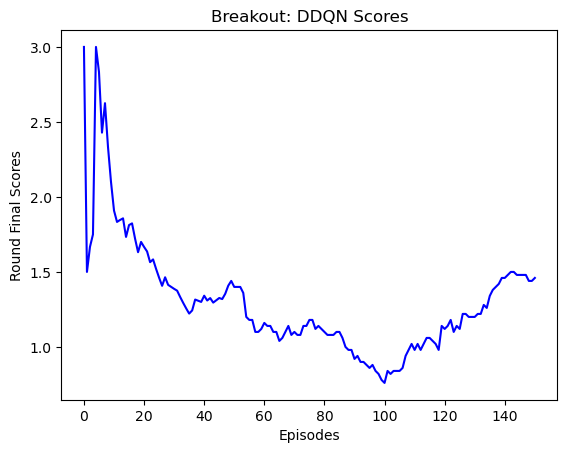

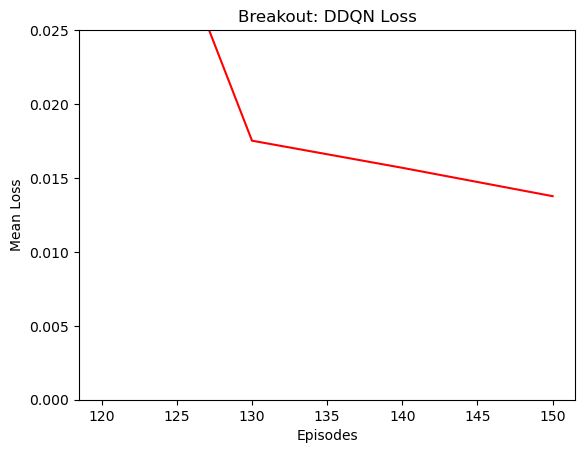

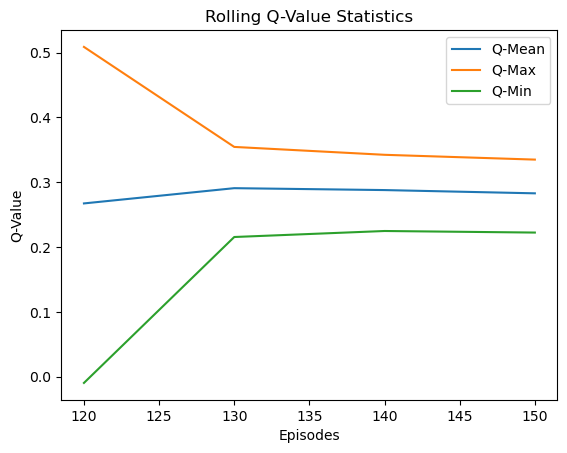

episode: 151   frame: 25277   score: 2.0   memory length: 24517   epsilon: 0.93982   train inerval: 4   steps: 195   lr: 0.0001   reward MA: 1.42 mean loss: 0.00837
episode: 152   frame: 25397   score: 0.0   memory length: 24632   epsilon: 0.93794   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.4 mean loss: 0.01512
episode: 153   frame: 25563   score: 1.0   memory length: 24793   epsilon: 0.93607   train inerval: 4   steps: 166   lr: 0.0001   reward MA: 1.4 mean loss: 0.0155
episode: 154   frame: 25683   score: 0.0   memory length: 24908   epsilon: 0.9342   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.4 mean loss: 0.01064
episode: 155   frame: 25902   score: 2.0   memory length: 25122   epsilon: 0.93233   train inerval: 4   steps: 219   lr: 0.0001   reward MA: 1.42 mean loss: 0.01403
episode: 156   frame: 26099   score: 2.0   memory length: 25314   epsilon: 0.93046   train inerval: 4   steps: 197   lr: 0.0001   reward MA: 1.44 mean loss: 0.01425
episode: 157   

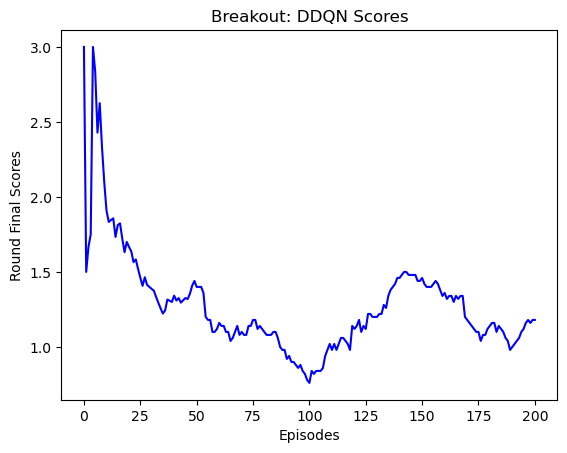

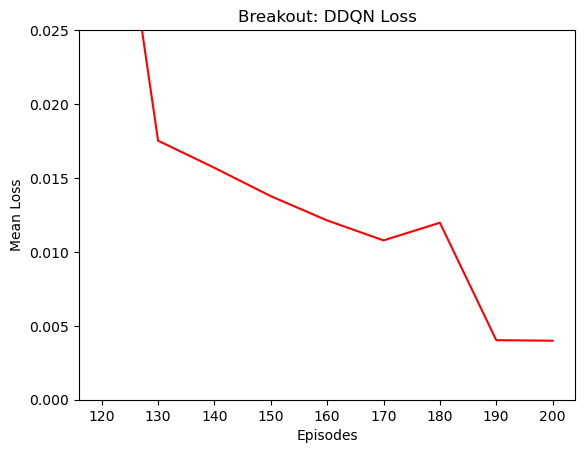

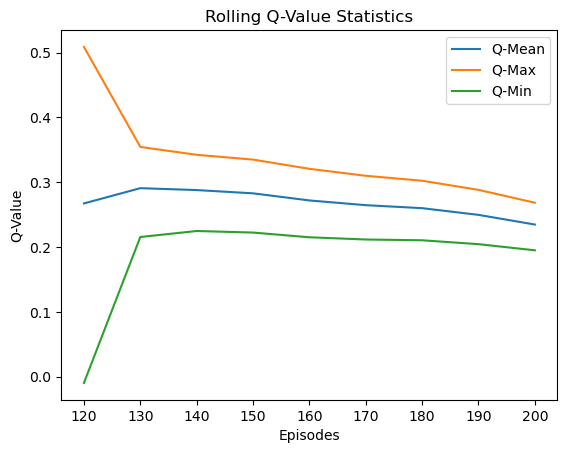

episode: 201   frame: 33659   score: 5.0   memory length: 32649   epsilon: 0.8503   train inerval: 4   steps: 315   lr: 0.0001   reward MA: 1.24 mean loss: 0.00455
episode: 202   frame: 33953   score: 4.0   memory length: 32938   epsilon: 0.8486   train inerval: 4   steps: 294   lr: 0.0001   reward MA: 1.32 mean loss: 0.00394
episode: 203   frame: 34073   score: 0.0   memory length: 33053   epsilon: 0.84691   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.3 mean loss: 0.0042
episode: 204   frame: 34316   score: 3.0   memory length: 33291   epsilon: 0.84521   train inerval: 4   steps: 243   lr: 0.0001   reward MA: 1.36 mean loss: 0.00383
episode: 205   frame: 34526   score: 3.0   memory length: 33496   epsilon: 0.84352   train inerval: 4   steps: 210   lr: 0.0001   reward MA: 1.38 mean loss: 0.00463
episode: 206   frame: 34692   score: 1.0   memory length: 33657   epsilon: 0.84183   train inerval: 4   steps: 166   lr: 0.0001   reward MA: 1.36 mean loss: 0.00419
episode: 207  

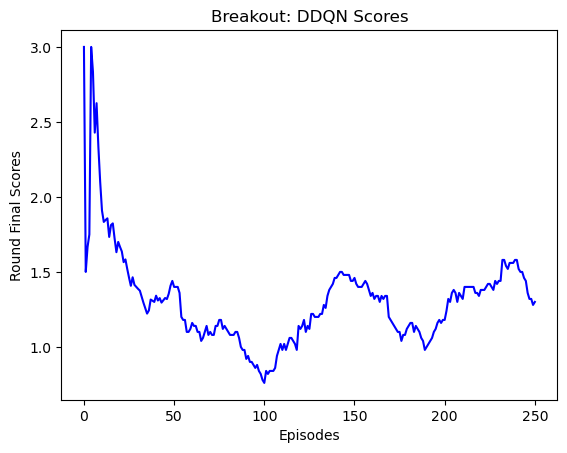

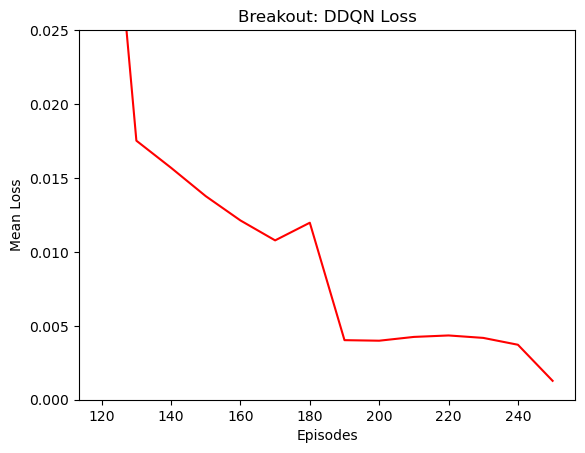

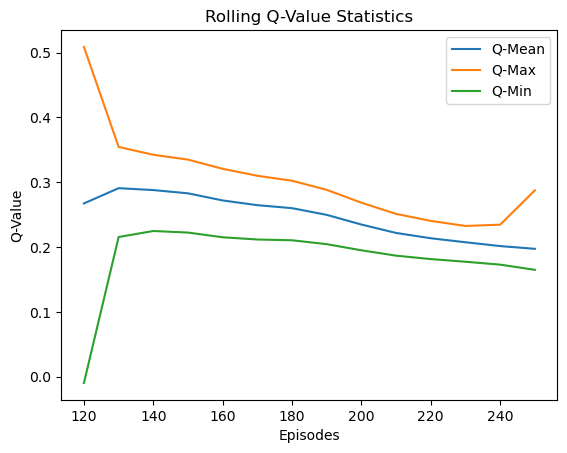

Checkpoint for episode 250 saved
episode: 251   frame: 41733   score: 2.0   memory length: 40473   epsilon: 0.76931   train inerval: 4   steps: 195   lr: 0.0001   reward MA: 1.24 mean loss: 0.00096
episode: 252   frame: 42056   score: 5.0   memory length: 40791   epsilon: 0.76777   train inerval: 4   steps: 323   lr: 0.0001   reward MA: 1.26 mean loss: 0.00045
episode: 253   frame: 42378   score: 5.0   memory length: 41108   epsilon: 0.76624   train inerval: 4   steps: 322   lr: 0.0001   reward MA: 1.36 mean loss: 0.00058
episode: 254   frame: 42576   score: 2.0   memory length: 41301   epsilon: 0.7647   train inerval: 4   steps: 198   lr: 0.0001   reward MA: 1.34 mean loss: 0.00046
episode: 255   frame: 42770   score: 2.0   memory length: 41490   epsilon: 0.76317   train inerval: 4   steps: 194   lr: 0.0001   reward MA: 1.32 mean loss: 0.00022
episode: 256   frame: 42936   score: 1.0   memory length: 41651   epsilon: 0.76165   train inerval: 4   steps: 166   lr: 0.0001   reward MA: 1.

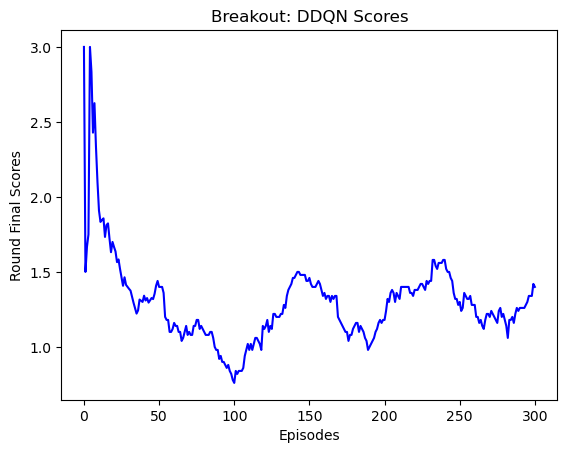

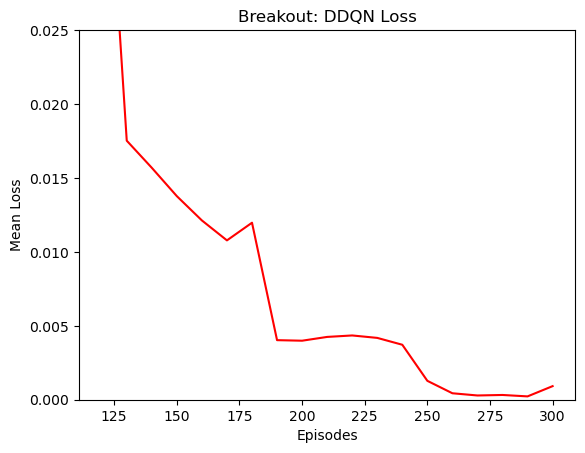

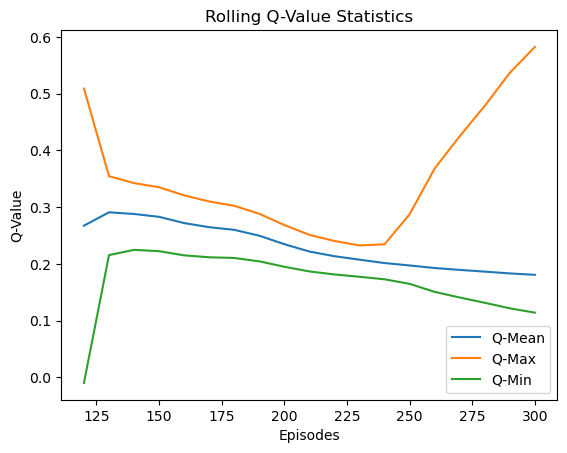

episode: 301   frame: 50375   score: 0.0   memory length: 48865   epsilon: 0.69603   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.36 mean loss: 0.00661
episode: 302   frame: 50644   score: 3.0   memory length: 49129   epsilon: 0.69464   train inerval: 4   steps: 269   lr: 0.0001   reward MA: 1.32 mean loss: 0.00365
episode: 303   frame: 50792   score: 1.0   memory length: 49272   epsilon: 0.69325   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.24 mean loss: 0.00235
episode: 304   frame: 51035   score: 3.0   memory length: 49510   epsilon: 0.69186   train inerval: 4   steps: 243   lr: 0.0001   reward MA: 1.26 mean loss: 0.00205
episode: 305   frame: 51375   score: 6.0   memory length: 49845   epsilon: 0.69048   train inerval: 4   steps: 340   lr: 0.0001   reward MA: 1.34 mean loss: 0.00164
episode: 306   frame: 51590   score: 2.0   memory length: 50055   epsilon: 0.6891   train inerval: 4   steps: 215   lr: 0.0001   reward MA: 1.36 mean loss: 0.00148
episode: 30

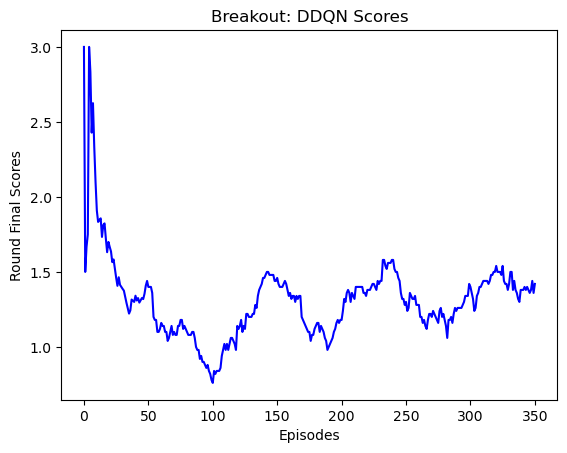

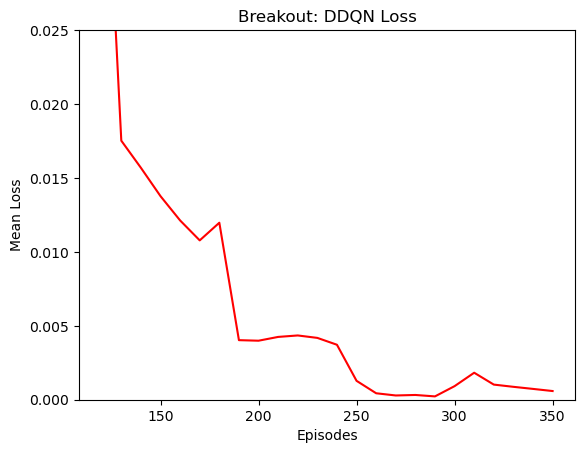

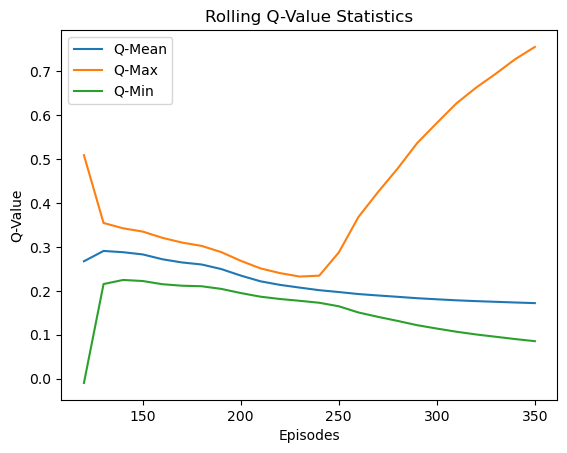

episode: 351   frame: 59122   score: 0.0   memory length: 57362   epsilon: 0.62973   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.42 mean loss: 0.00051
episode: 352   frame: 59242   score: 0.0   memory length: 57477   epsilon: 0.62847   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.36 mean loss: 0.00049
episode: 353   frame: 59459   score: 2.0   memory length: 57689   epsilon: 0.62721   train inerval: 4   steps: 217   lr: 0.0001   reward MA: 1.38 mean loss: 0.00079
episode: 354   frame: 59579   score: 0.0   memory length: 57804   epsilon: 0.62596   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.32 mean loss: 0.00071
episode: 355   frame: 59745   score: 1.0   memory length: 57965   epsilon: 0.62471   train inerval: 4   steps: 166   lr: 0.0001   reward MA: 1.22 mean loss: 0.00066
episode: 356   frame: 59962   score: 2.0   memory length: 58177   epsilon: 0.62346   train inerval: 4   steps: 217   lr: 0.0001   reward MA: 1.22 mean loss: 0.00067
Target net

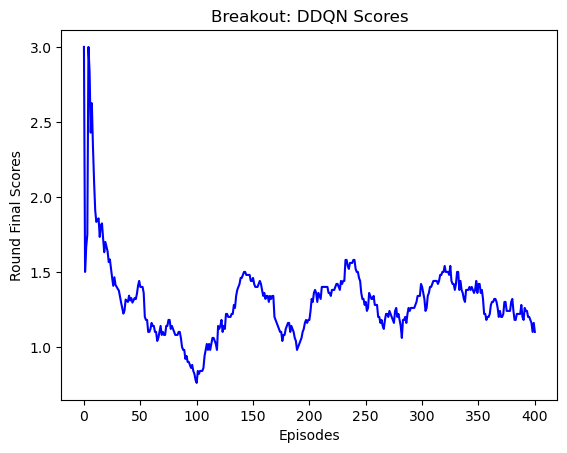

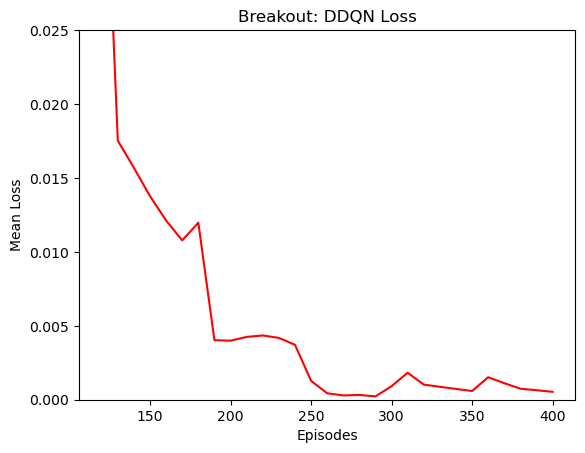

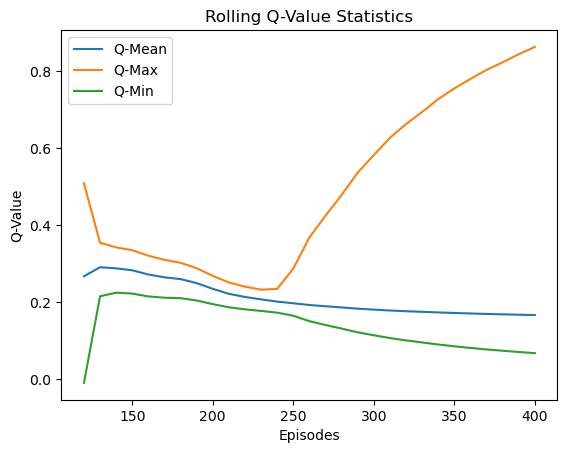

episode: 401   frame: 67439   score: 2.0   memory length: 65429   epsilon: 0.56975   train inerval: 4   steps: 221   lr: 0.0001   reward MA: 1.14 mean loss: 0.00054
episode: 402   frame: 67559   score: 0.0   memory length: 65544   epsilon: 0.56861   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.14 mean loss: 0.00041
episode: 403   frame: 67738   score: 2.0   memory length: 65718   epsilon: 0.56747   train inerval: 4   steps: 179   lr: 0.0001   reward MA: 1.14 mean loss: 0.00067
episode: 404   frame: 67934   score: 2.0   memory length: 65909   epsilon: 0.56634   train inerval: 4   steps: 196   lr: 0.0001   reward MA: 1.18 mean loss: 0.00065
episode: 405   frame: 68100   score: 1.0   memory length: 66070   epsilon: 0.5652   train inerval: 4   steps: 166   lr: 0.0001   reward MA: 1.18 mean loss: 0.00052
episode: 406   frame: 68425   score: 5.0   memory length: 66390   epsilon: 0.56407   train inerval: 4   steps: 325   lr: 0.0001   reward MA: 1.24 mean loss: 0.00043
episode: 40

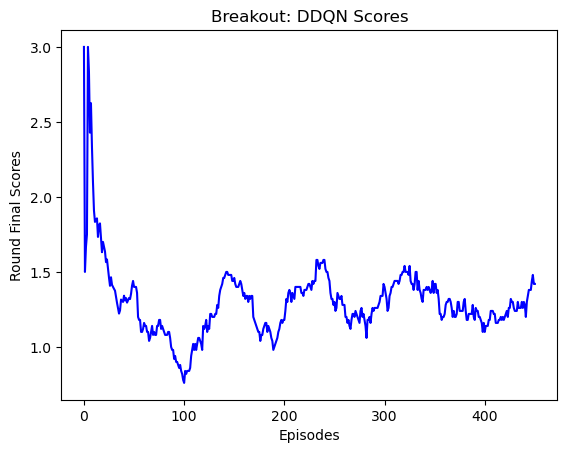

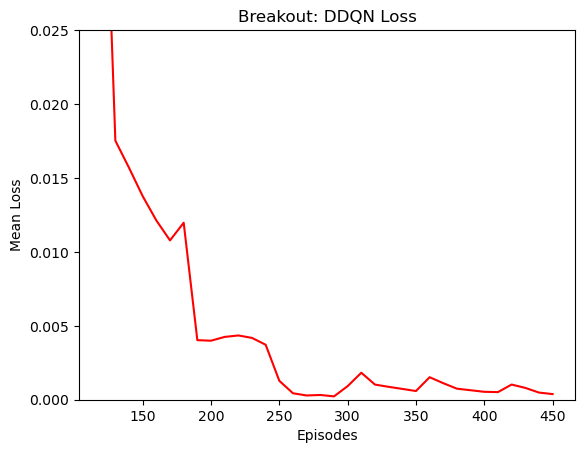

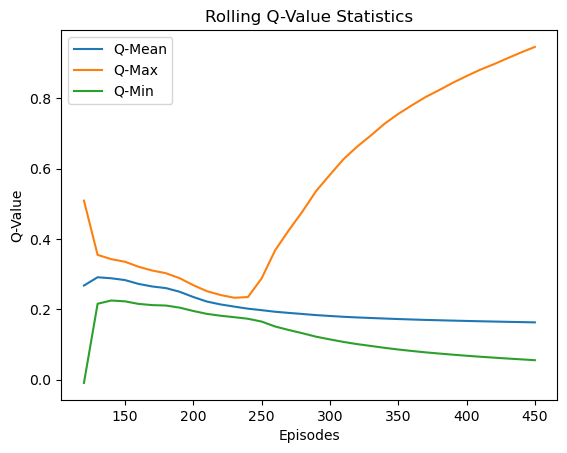

episode: 451   frame: 75964   score: 1.0   memory length: 73704   epsilon: 0.51548   train inerval: 4   steps: 166   lr: 0.0001   reward MA: 1.4 mean loss: 0.00026
episode: 452   frame: 76112   score: 1.0   memory length: 73847   epsilon: 0.51445   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.42 mean loss: 0.00038
episode: 453   frame: 76260   score: 1.0   memory length: 73990   epsilon: 0.51342   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.4 mean loss: 0.00044
episode: 454   frame: 76456   score: 2.0   memory length: 74181   epsilon: 0.51239   train inerval: 4   steps: 196   lr: 0.0001   reward MA: 1.4 mean loss: 0.00033
episode: 455   frame: 76576   score: 0.0   memory length: 74296   epsilon: 0.51137   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.38 mean loss: 0.00033
episode: 456   frame: 76744   score: 1.0   memory length: 74459   epsilon: 0.51034   train inerval: 4   steps: 168   lr: 0.0001   reward MA: 1.3 mean loss: 0.00054
episode: 457  

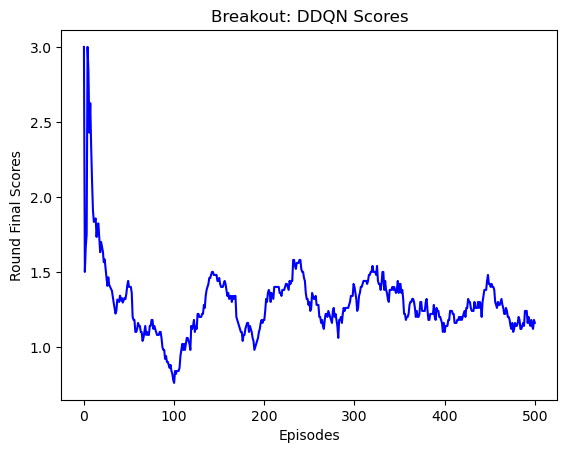

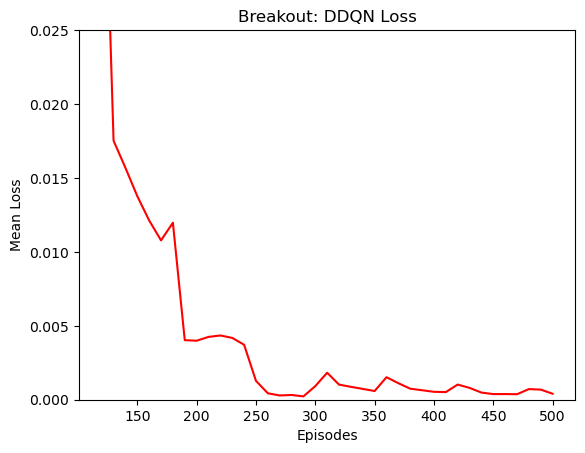

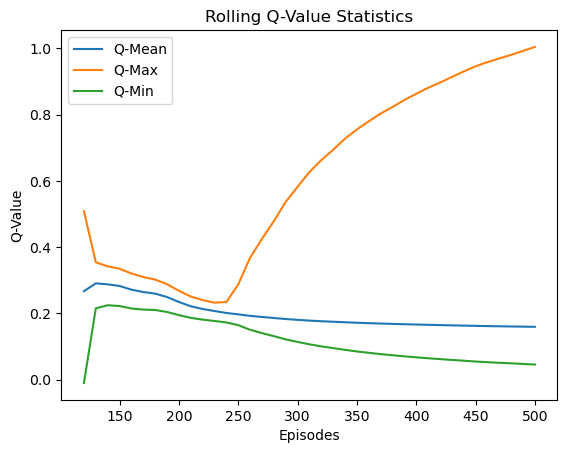

Checkpoint for episode 500 saved
episode: 501   frame: 83932   score: 0.0   memory length: 81422   epsilon: 0.46638   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.14 mean loss: 0.00024
episode: 502   frame: 84253   score: 9.0   memory length: 81738   epsilon: 0.46544   train inerval: 4   steps: 321   lr: 0.0001   reward MA: 1.3 mean loss: 0.00025
episode: 503   frame: 84449   score: 2.0   memory length: 81929   epsilon: 0.46451   train inerval: 4   steps: 196   lr: 0.0001   reward MA: 1.32 mean loss: 0.00034
episode: 504   frame: 84597   score: 1.0   memory length: 82072   epsilon: 0.46358   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.3 mean loss: 0.00041
episode: 505   frame: 84765   score: 1.0   memory length: 82235   epsilon: 0.46266   train inerval: 4   steps: 168   lr: 0.0001   reward MA: 1.32 mean loss: 0.00042
episode: 506   frame: 84885   score: 0.0   memory length: 82350   epsilon: 0.46173   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.3

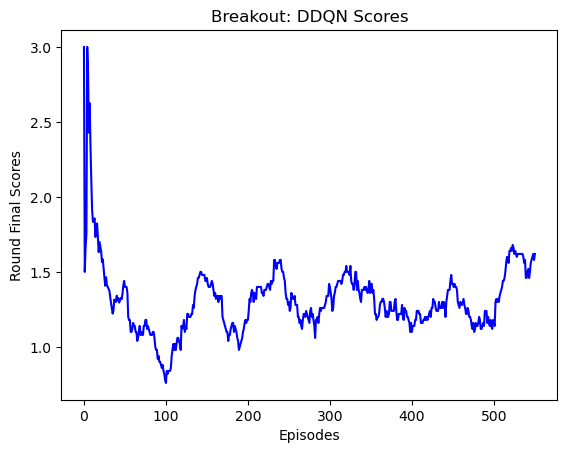

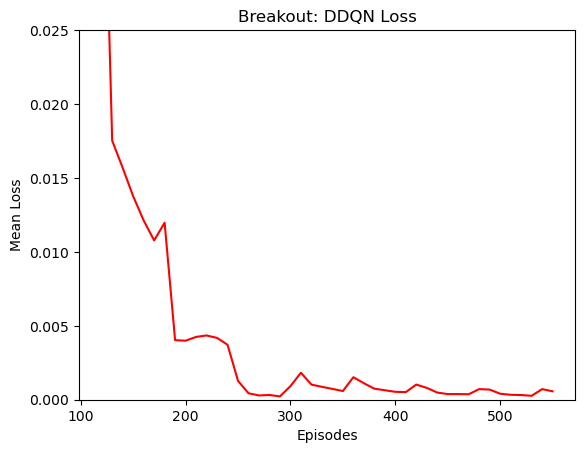

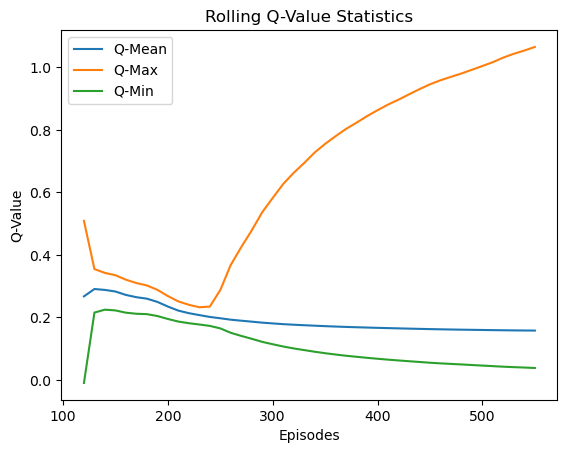

episode: 551   frame: 92653   score: 1.0   memory length: 89893   epsilon: 0.42195   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.64 mean loss: 0.00048
episode: 552   frame: 92985   score: 5.0   memory length: 90220   epsilon: 0.42111   train inerval: 4   steps: 332   lr: 0.0001   reward MA: 1.56 mean loss: 0.00026
episode: 553   frame: 93105   score: 0.0   memory length: 90335   epsilon: 0.42027   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.52 mean loss: 0.00031
episode: 554   frame: 93253   score: 1.0   memory length: 90478   epsilon: 0.41943   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.52 mean loss: 0.00026
episode: 555   frame: 93403   score: 1.0   memory length: 90623   epsilon: 0.41859   train inerval: 4   steps: 150   lr: 0.0001   reward MA: 1.52 mean loss: 0.00025
episode: 556   frame: 93523   score: 0.0   memory length: 90738   epsilon: 0.41775   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.52 mean loss: 0.00038
episode: 5

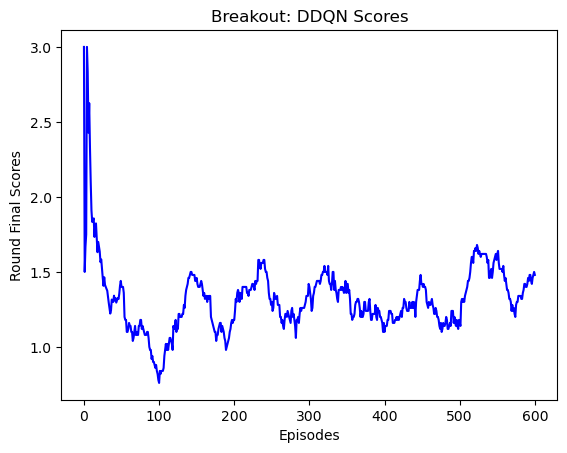

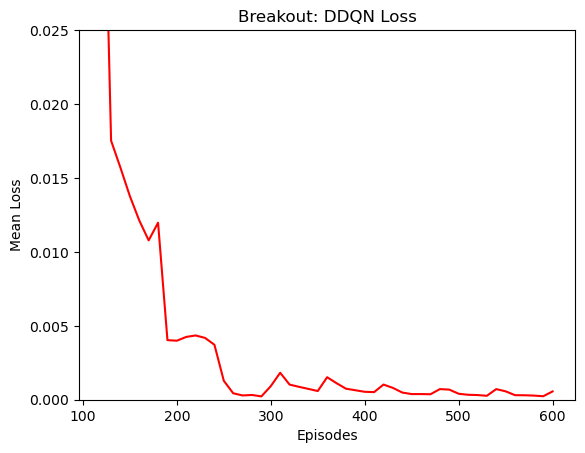

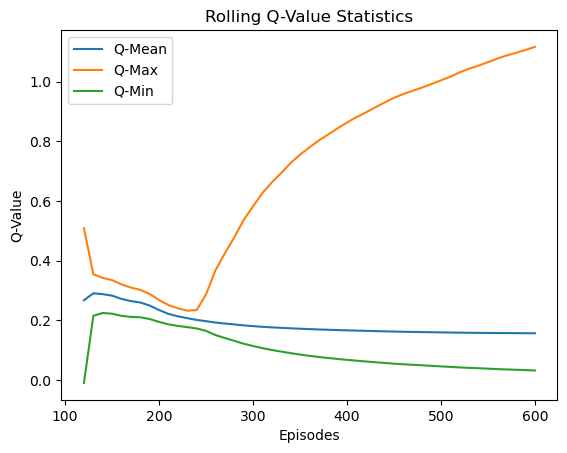

episode: 601   frame: 101266   score: 2.0   memory length: 98256   epsilon: 0.38176   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 1.5 mean loss: 0.00046
episode: 602   frame: 101462   score: 2.0   memory length: 98447   epsilon: 0.381   train inerval: 4   steps: 196   lr: 0.0001   reward MA: 1.44 mean loss: 0.00048
episode: 603   frame: 101682   score: 2.0   memory length: 98662   epsilon: 0.38023   train inerval: 4   steps: 220   lr: 0.0001   reward MA: 1.48 mean loss: 0.00071
episode: 604   frame: 101830   score: 1.0   memory length: 98805   epsilon: 0.37947   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.48 mean loss: 0.00071
episode: 605   frame: 101978   score: 1.0   memory length: 98948   epsilon: 0.37872   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.48 mean loss: 0.00036
episode: 606   frame: 102144   score: 1.0   memory length: 99109   epsilon: 0.37796   train inerval: 4   steps: 166   lr: 0.0001   reward MA: 1.5 mean loss: 0.00065
episode:

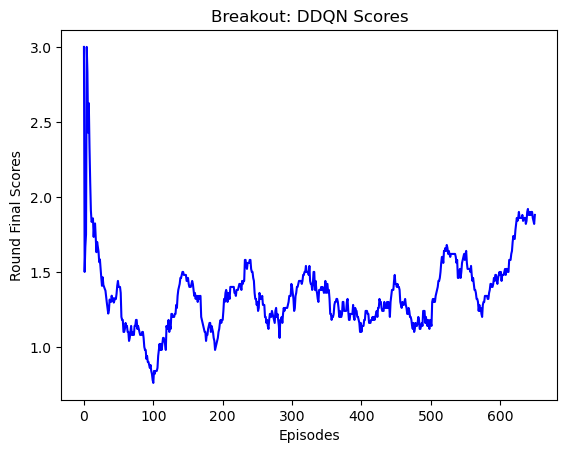

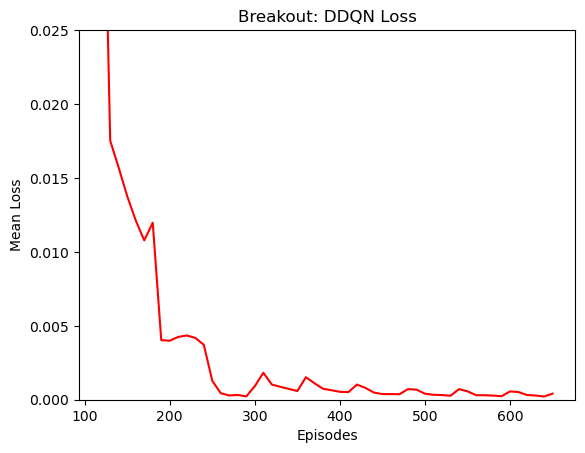

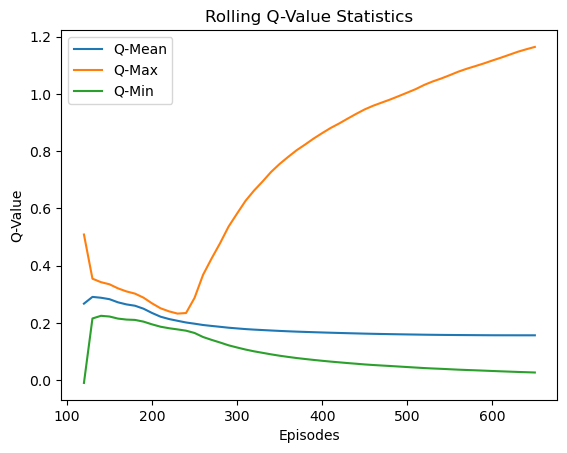

episode: 651   frame: 110727   score: 3.0   memory length: 107467   epsilon: 0.3454   train inerval: 4   steps: 226   lr: 0.0001   reward MA: 1.9 mean loss: 0.00086
episode: 652   frame: 110875   score: 1.0   memory length: 107610   epsilon: 0.34471   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.88 mean loss: 0.00066
episode: 653   frame: 111023   score: 1.0   memory length: 107753   epsilon: 0.34402   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.86 mean loss: 0.0005
episode: 654   frame: 111171   score: 1.0   memory length: 107896   epsilon: 0.34333   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.86 mean loss: 0.0005
episode: 655   frame: 111319   score: 1.0   memory length: 108039   epsilon: 0.34264   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.86 mean loss: 0.00066
episode: 656   frame: 111562   score: 3.0   memory length: 108277   epsilon: 0.34196   train inerval: 4   steps: 243   lr: 0.0001   reward MA: 1.9 mean loss: 0.00057
epi

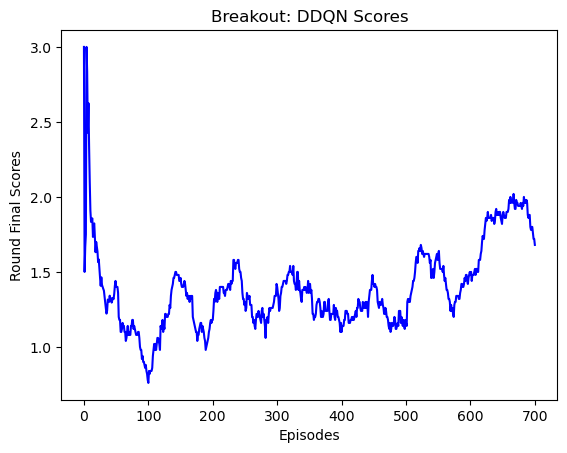

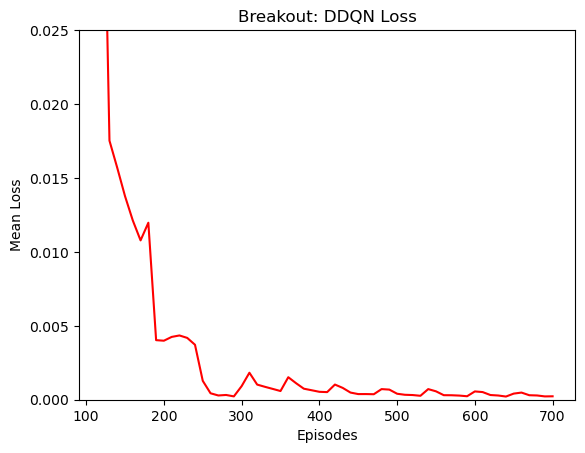

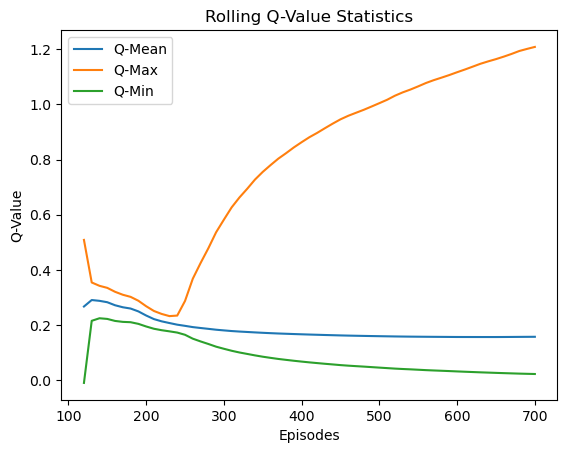

episode: 701   frame: 119725   score: 3.0   memory length: 116215   epsilon: 0.3125   train inerval: 4   steps: 223   lr: 0.0001   reward MA: 1.68 mean loss: 0.00014
episode: 702   frame: 119873   score: 1.0   memory length: 116358   epsilon: 0.31187   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.68 mean loss: 0.00017
Target network updated at frame:  120000
episode: 703   frame: 120051   score: 2.0   memory length: 116531   epsilon: 0.31125   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 1.7 mean loss: 0.00022
episode: 704   frame: 120247   score: 2.0   memory length: 116722   epsilon: 0.31062   train inerval: 4   steps: 196   lr: 0.0001   reward MA: 1.72 mean loss: 0.0006
episode: 705   frame: 120413   score: 1.0   memory length: 116883   epsilon: 0.31   train inerval: 4   steps: 166   lr: 0.0001   reward MA: 1.72 mean loss: 0.00118
episode: 706   frame: 120579   score: 1.0   memory length: 117044   epsilon: 0.30938   train inerval: 4   steps: 166   lr: 0.0001 

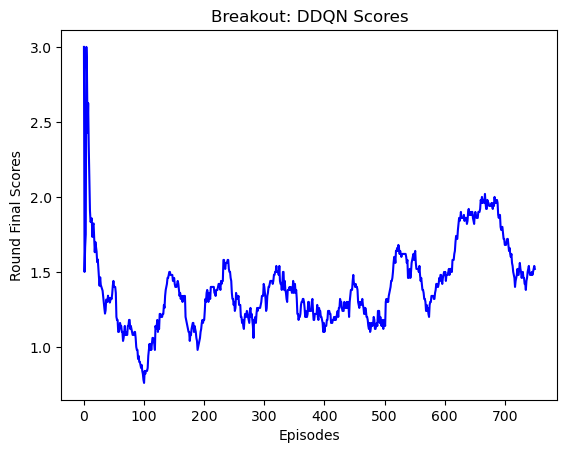

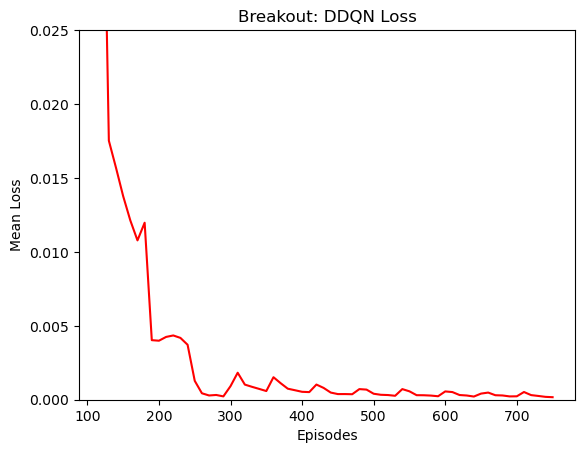

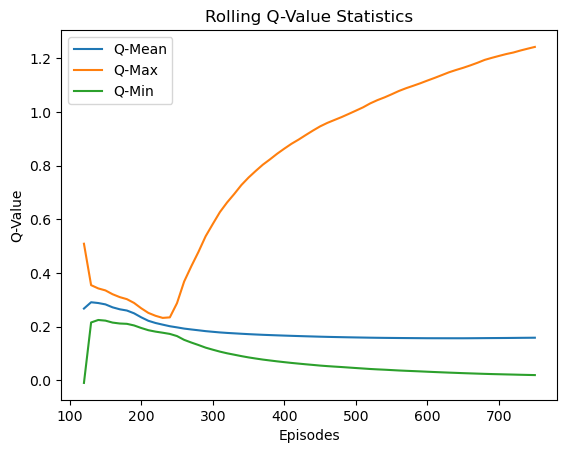

Checkpoint for episode 750 saved
episode: 751   frame: 128214   score: 1.0   memory length: 124454   epsilon: 0.28273   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.48 mean loss: 0.00029
episode: 752   frame: 128423   score: 3.0   memory length: 124658   epsilon: 0.28216   train inerval: 4   steps: 209   lr: 0.0001   reward MA: 1.52 mean loss: 0.00025
episode: 753   frame: 128543   score: 0.0   memory length: 124773   epsilon: 0.2816   train inerval: 4   steps: 120   lr: 0.0001   reward MA: 1.48 mean loss: 0.00014
episode: 754   frame: 128722   score: 2.0   memory length: 124947   epsilon: 0.28104   train inerval: 4   steps: 179   lr: 0.0001   reward MA: 1.48 mean loss: 0.00019
episode: 755   frame: 128999   score: 4.0   memory length: 125219   epsilon: 0.28047   train inerval: 4   steps: 277   lr: 0.0001   reward MA: 1.54 mean loss: 0.00015
episode: 756   frame: 129147   score: 1.0   memory length: 125362   epsilon: 0.27991   train inerval: 4   steps: 148   lr: 0.0001   r

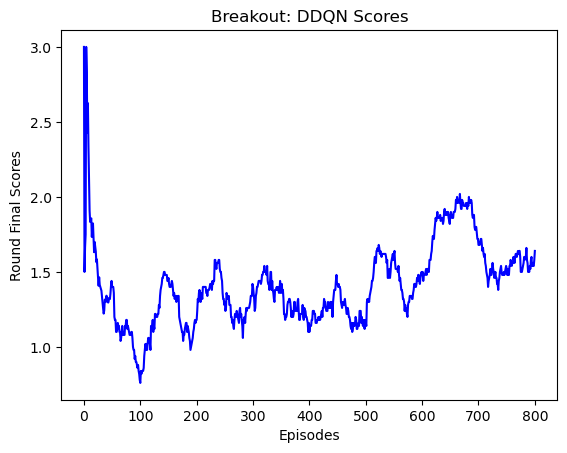

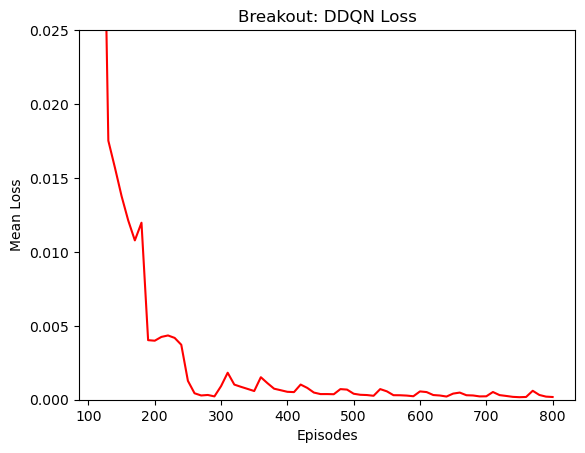

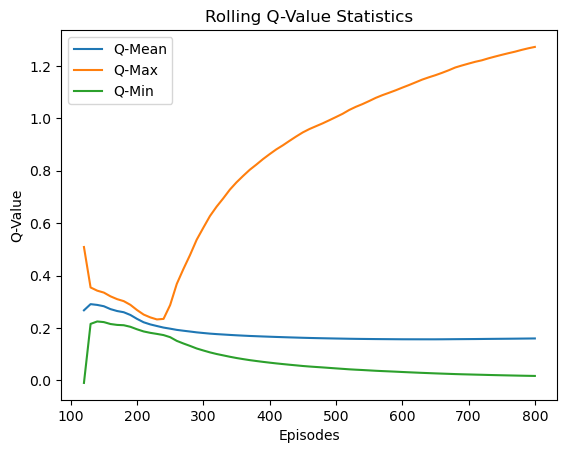

episode: 801   frame: 137066   score: 4.0   memory length: 133056   epsilon: 0.2558   train inerval: 4   steps: 238   lr: 0.0001   reward MA: 1.7 mean loss: 0.00015
episode: 802   frame: 137243   score: 2.0   memory length: 133228   epsilon: 0.25529   train inerval: 4   steps: 177   lr: 0.0001   reward MA: 1.68 mean loss: 0.00021
episode: 803   frame: 137421   score: 2.0   memory length: 133401   epsilon: 0.25478   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 1.72 mean loss: 0.0002
episode: 804   frame: 137569   score: 1.0   memory length: 133544   epsilon: 0.25427   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 1.7 mean loss: 0.00016
episode: 805   frame: 137856   score: 5.0   memory length: 133826   epsilon: 0.25376   train inerval: 4   steps: 287   lr: 0.0001   reward MA: 1.72 mean loss: 0.0002
episode: 806   frame: 138024   score: 1.0   memory length: 133989   epsilon: 0.25325   train inerval: 4   steps: 168   lr: 0.0001   reward MA: 1.72 mean loss: 0.00015
epi

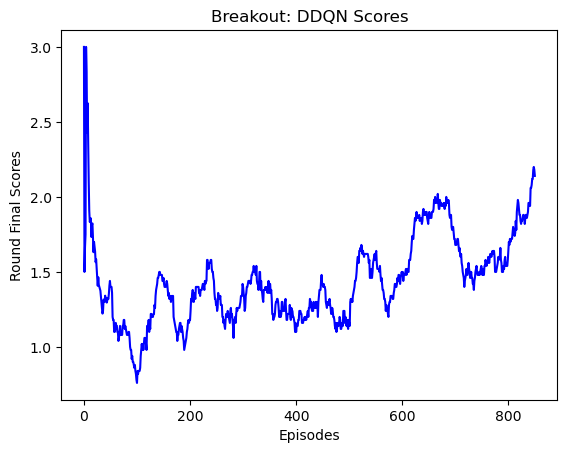

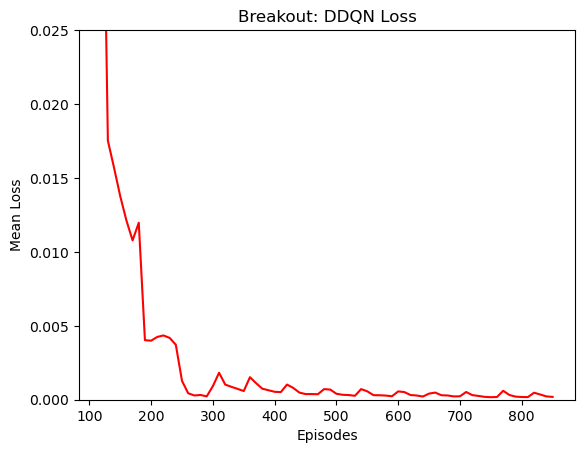

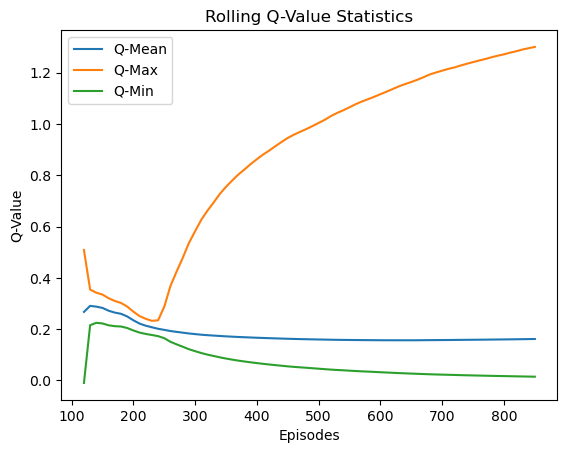

episode: 851   frame: 146529   score: 3.0   memory length: 142269   epsilon: 0.23143   train inerval: 4   steps: 227   lr: 0.0001   reward MA: 2.12 mean loss: 0.0002
episode: 852   frame: 146707   score: 2.0   memory length: 142442   epsilon: 0.23097   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 2.12 mean loss: 0.00031
episode: 853   frame: 146855   score: 1.0   memory length: 142585   epsilon: 0.23051   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 2.1 mean loss: 0.00033
episode: 854   frame: 147003   score: 1.0   memory length: 142728   epsilon: 0.23005   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 2.1 mean loss: 0.00019
episode: 855   frame: 147230   score: 3.0   memory length: 142950   epsilon: 0.22959   train inerval: 4   steps: 227   lr: 0.0001   reward MA: 2.06 mean loss: 0.00016
episode: 856   frame: 147494   score: 3.0   memory length: 143209   epsilon: 0.22913   train inerval: 4   steps: 264   lr: 0.0001   reward MA: 2.1 mean loss: 0.00015
ep

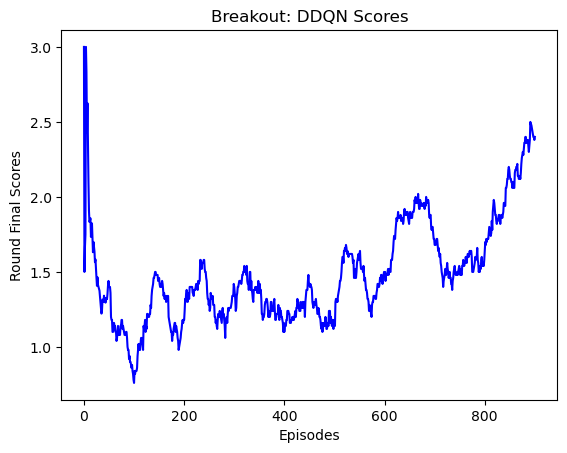

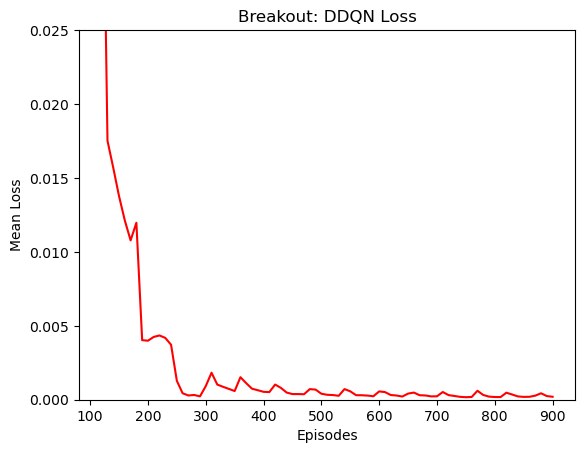

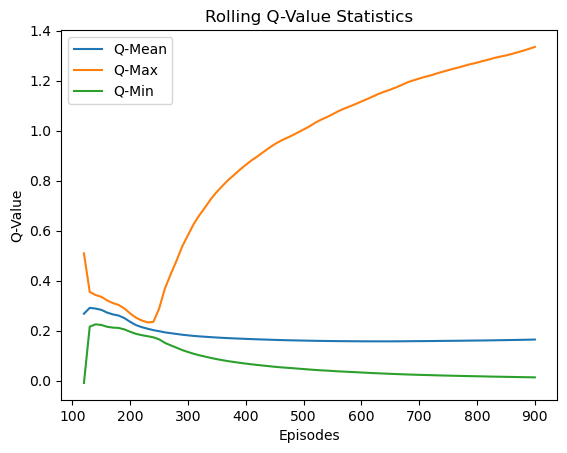

episode: 901   frame: 156400   score: 1.0   memory length: 151890   epsilon: 0.20939   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 2.36 mean loss: 0.00023
episode: 902   frame: 156548   score: 1.0   memory length: 152033   epsilon: 0.20897   train inerval: 4   steps: 148   lr: 0.0001   reward MA: 2.34 mean loss: 0.00022
episode: 903   frame: 156726   score: 2.0   memory length: 152206   epsilon: 0.20855   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 2.36 mean loss: 0.00023
episode: 904   frame: 156955   score: 3.0   memory length: 152430   epsilon: 0.20813   train inerval: 4   steps: 229   lr: 0.0001   reward MA: 2.4 mean loss: 0.00021
episode: 905   frame: 157237   score: 5.0   memory length: 152707   epsilon: 0.20772   train inerval: 4   steps: 282   lr: 0.0001   reward MA: 2.44 mean loss: 0.00019
episode: 906   frame: 157477   score: 4.0   memory length: 152942   epsilon: 0.2073   train inerval: 4   steps: 240   lr: 0.0001   reward MA: 2.46 mean loss: 0.00021


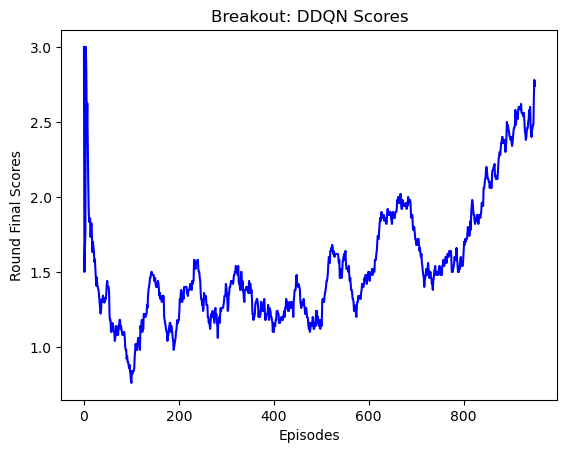

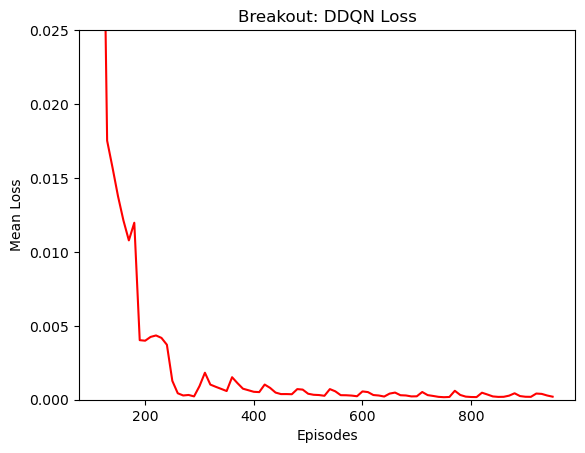

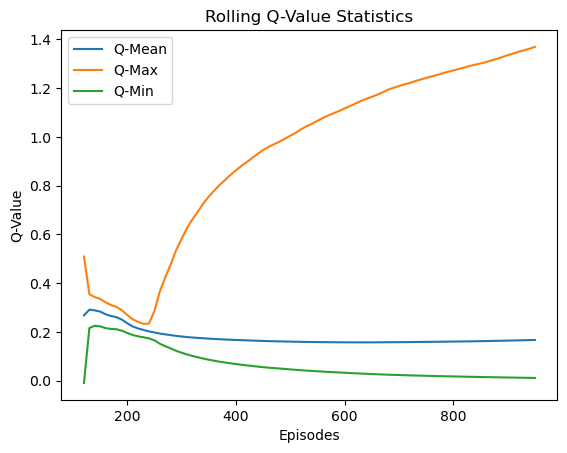

episode: 951   frame: 166711   score: 3.0   memory length: 161951   epsilon: 0.18944   train inerval: 4   steps: 209   lr: 0.0001   reward MA: 2.78 mean loss: 0.00018
episode: 952   frame: 166889   score: 2.0   memory length: 162124   epsilon: 0.18906   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 2.8 mean loss: 0.00043
episode: 953   frame: 167067   score: 2.0   memory length: 162297   epsilon: 0.18869   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 2.8 mean loss: 0.00038
episode: 954   frame: 167341   score: 4.0   memory length: 162566   epsilon: 0.18831   train inerval: 4   steps: 274   lr: 0.0001   reward MA: 2.82 mean loss: 0.00048
episode: 955   frame: 167519   score: 2.0   memory length: 162739   epsilon: 0.18793   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 2.76 mean loss: 0.00036
episode: 956   frame: 167748   score: 3.0   memory length: 162963   epsilon: 0.18756   train inerval: 4   steps: 229   lr: 0.0001   reward MA: 2.74 mean loss: 0.00021


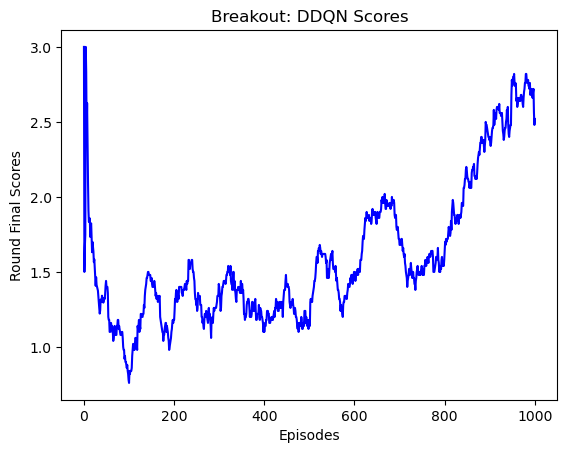

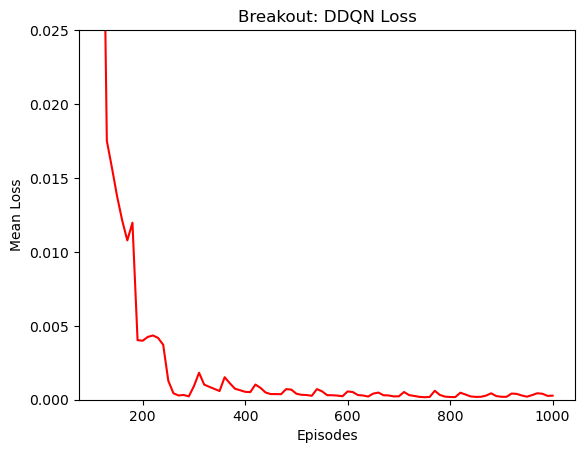

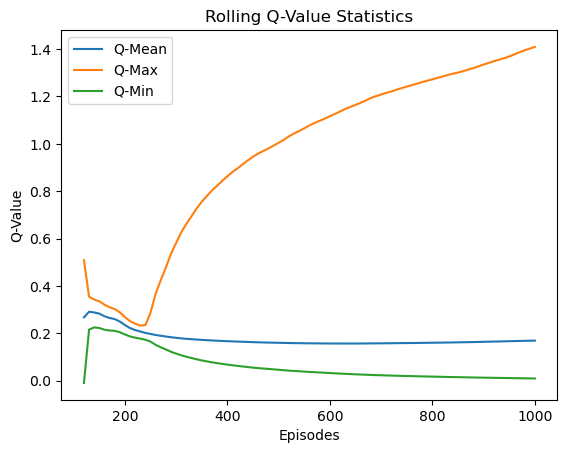

Checkpoint for episode 1000 saved
episode: 1001   frame: 176996   score: 5.0   memory length: 171986   epsilon: 0.1714   train inerval: 4   steps: 293   lr: 0.0001   reward MA: 2.56 mean loss: 0.00026
episode: 1002   frame: 177220   score: 3.0   memory length: 172205   epsilon: 0.17106   train inerval: 4   steps: 224   lr: 0.0001   reward MA: 2.58 mean loss: 0.00025
episode: 1003   frame: 177429   score: 3.0   memory length: 172409   epsilon: 0.17071   train inerval: 4   steps: 209   lr: 0.0001   reward MA: 2.6 mean loss: 0.00018
episode: 1004   frame: 177638   score: 3.0   memory length: 172613   epsilon: 0.17037   train inerval: 4   steps: 209   lr: 0.0001   reward MA: 2.58 mean loss: 0.00018
episode: 1005   frame: 177847   score: 3.0   memory length: 172817   epsilon: 0.17003   train inerval: 4   steps: 209   lr: 0.0001   reward MA: 2.6 mean loss: 0.00019
episode: 1006   frame: 177995   score: 1.0   memory length: 172960   epsilon: 0.16969   train inerval: 4   steps: 148   lr: 0.000

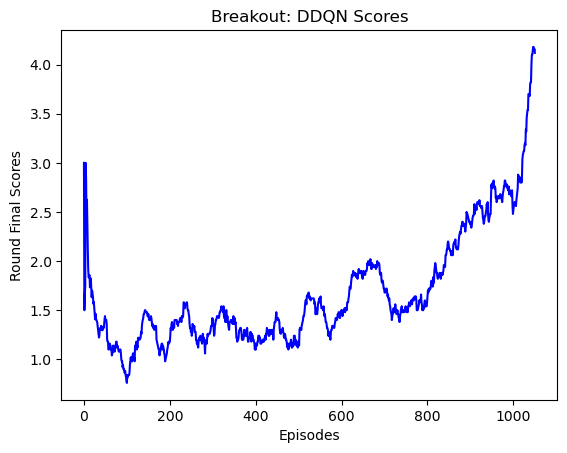

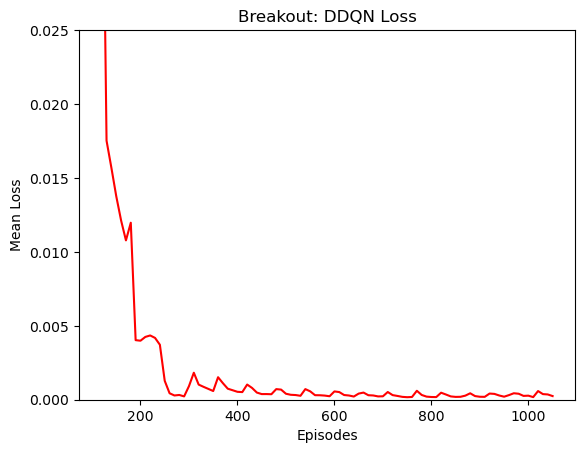

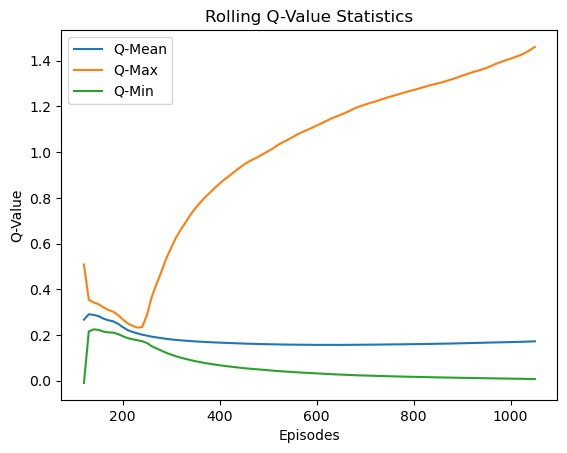

episode: 1051   frame: 188957   score: 2.0   memory length: 183697   epsilon: 0.15507   train inerval: 4   steps: 177   lr: 0.0001   reward MA: 4.06 mean loss: 0.0002
episode: 1052   frame: 189166   score: 3.0   memory length: 183901   epsilon: 0.15476   train inerval: 4   steps: 209   lr: 0.0001   reward MA: 4.06 mean loss: 0.00023
episode: 1053   frame: 189536   score: 6.0   memory length: 184266   epsilon: 0.15445   train inerval: 4   steps: 370   lr: 0.0001   reward MA: 4.12 mean loss: 0.00026
episode: 1054   frame: 189714   score: 2.0   memory length: 184439   epsilon: 0.15414   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 4.1 mean loss: 0.00022
episode: 1055   frame: 189892   score: 2.0   memory length: 184612   epsilon: 0.15384   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 4.08 mean loss: 0.00025
Target network updated at frame:  190000
episode: 1056   frame: 190133   score: 7.0   memory length: 184848   epsilon: 0.15353   train inerval: 4   steps: 241   l

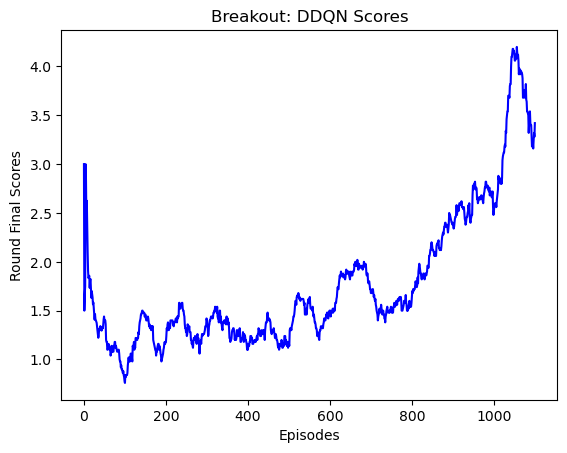

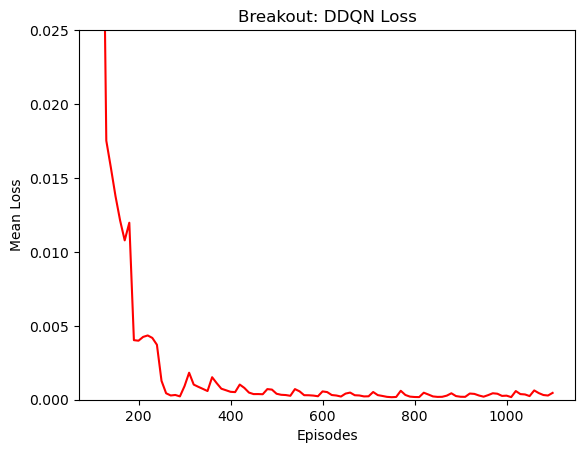

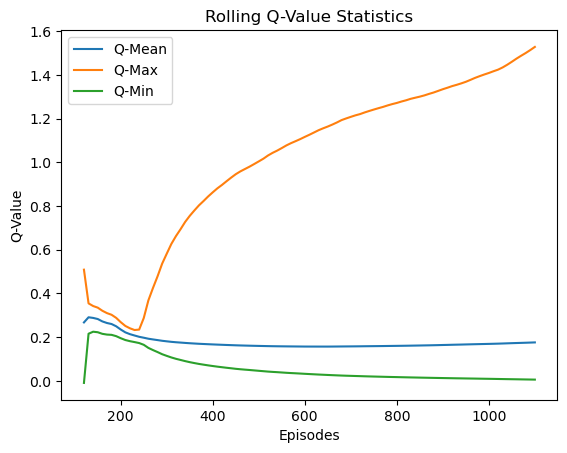

episode: 1101   frame: 200637   score: 2.0   memory length: 195127   epsilon: 0.1403   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 3.42 mean loss: 0.00111
episode: 1102   frame: 200960   score: 5.0   memory length: 195445   epsilon: 0.14002   train inerval: 4   steps: 323   lr: 0.0001   reward MA: 3.46 mean loss: 0.00099
episode: 1103   frame: 201158   score: 2.0   memory length: 195638   epsilon: 0.13974   train inerval: 4   steps: 198   lr: 0.0001   reward MA: 3.38 mean loss: 0.00094
episode: 1104   frame: 201589   score: 7.0   memory length: 196064   epsilon: 0.13946   train inerval: 4   steps: 431   lr: 0.0001   reward MA: 3.48 mean loss: 0.00067
episode: 1105   frame: 201798   score: 3.0   memory length: 196268   epsilon: 0.13918   train inerval: 4   steps: 209   lr: 0.0001   reward MA: 3.5 mean loss: 0.00064
episode: 1106   frame: 201976   score: 2.0   memory length: 196441   epsilon: 0.1389   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 3.4 mean loss: 0.00

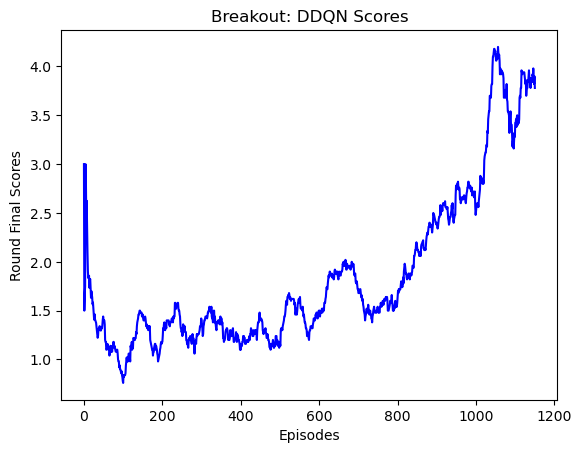

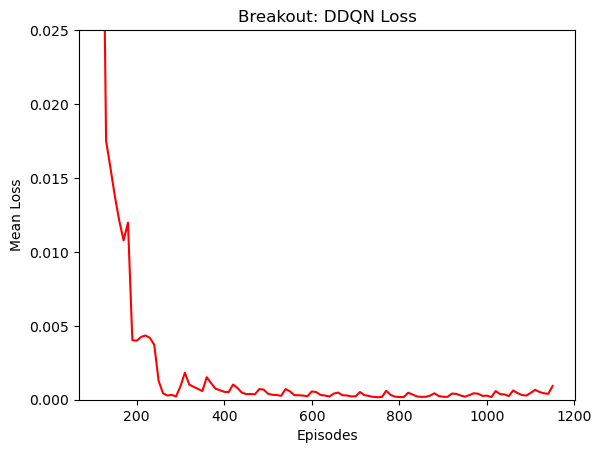

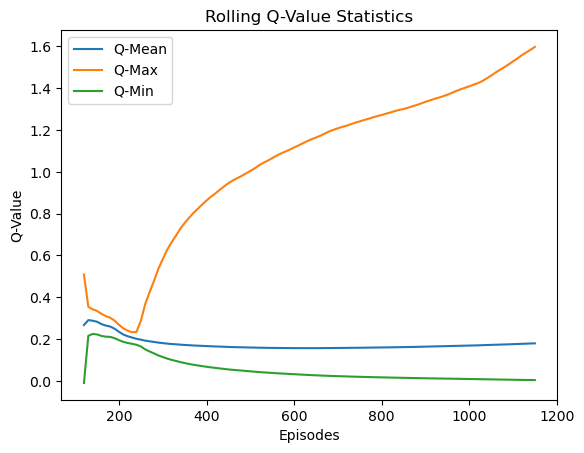

episode: 1151   frame: 212321   score: 2.0   memory length: 200000   epsilon: 0.12694   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 3.78 mean loss: 0.0007
episode: 1152   frame: 212499   score: 2.0   memory length: 200000   epsilon: 0.12668   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 3.72 mean loss: 0.00069
episode: 1153   frame: 212724   score: 3.0   memory length: 200000   epsilon: 0.12643   train inerval: 4   steps: 225   lr: 0.0001   reward MA: 3.74 mean loss: 0.00065
episode: 1154   frame: 213100   score: 8.0   memory length: 200000   epsilon: 0.12618   train inerval: 4   steps: 376   lr: 0.0001   reward MA: 3.76 mean loss: 0.00062
episode: 1155   frame: 213309   score: 3.0   memory length: 200000   epsilon: 0.12592   train inerval: 4   steps: 209   lr: 0.0001   reward MA: 3.76 mean loss: 0.00061
episode: 1156   frame: 213564   score: 4.0   memory length: 200000   epsilon: 0.12567   train inerval: 4   steps: 255   lr: 0.0001   reward MA: 3.8 mean loss: 0.

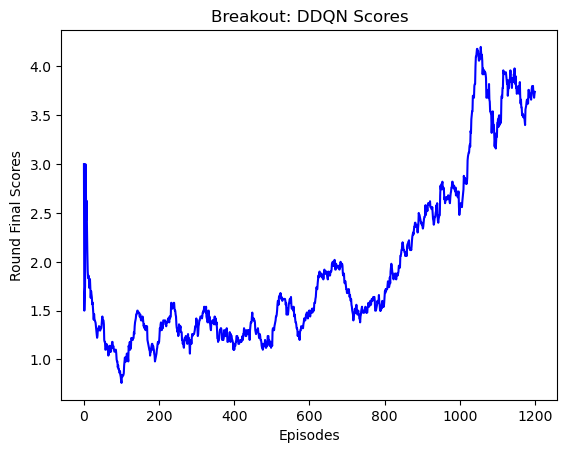

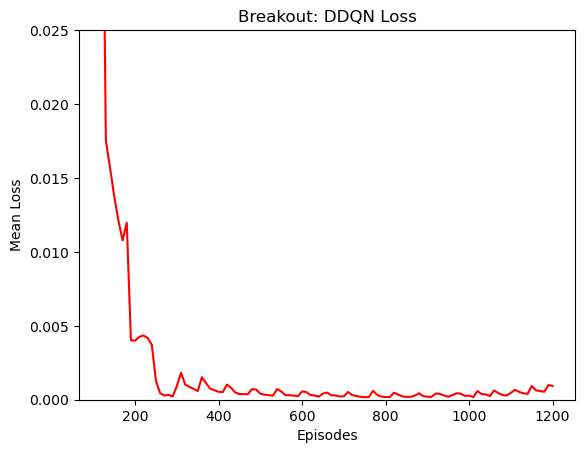

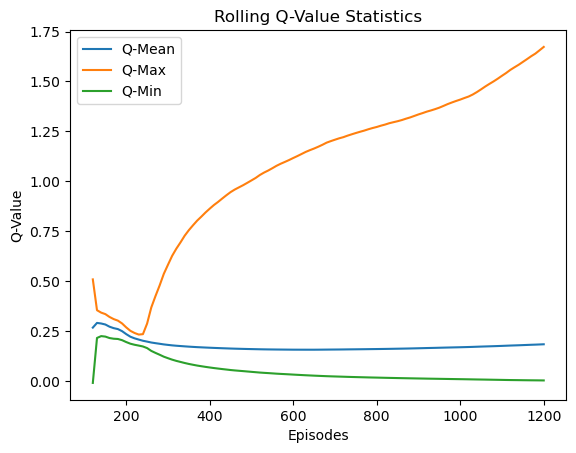

episode: 1201   frame: 223508   score: 2.0   memory length: 200000   epsilon: 0.11485   train inerval: 4   steps: 194   lr: 0.0001   reward MA: 3.74 mean loss: 0.00082
episode: 1202   frame: 223813   score: 5.0   memory length: 200000   epsilon: 0.11462   train inerval: 4   steps: 305   lr: 0.0001   reward MA: 3.8 mean loss: 0.00089
episode: 1203   frame: 224069   score: 4.0   memory length: 200000   epsilon: 0.11439   train inerval: 4   steps: 256   lr: 0.0001   reward MA: 3.82 mean loss: 0.001
episode: 1204   frame: 224331   score: 11.0   memory length: 200000   epsilon: 0.11416   train inerval: 4   steps: 262   lr: 0.0001   reward MA: 3.88 mean loss: 0.00095
episode: 1205   frame: 224626   score: 5.0   memory length: 200000   epsilon: 0.11393   train inerval: 4   steps: 295   lr: 0.0001   reward MA: 3.92 mean loss: 0.00089
episode: 1206   frame: 224867   score: 3.0   memory length: 200000   epsilon: 0.1137   train inerval: 4   steps: 241   lr: 0.0001   reward MA: 3.9 mean loss: 0.00

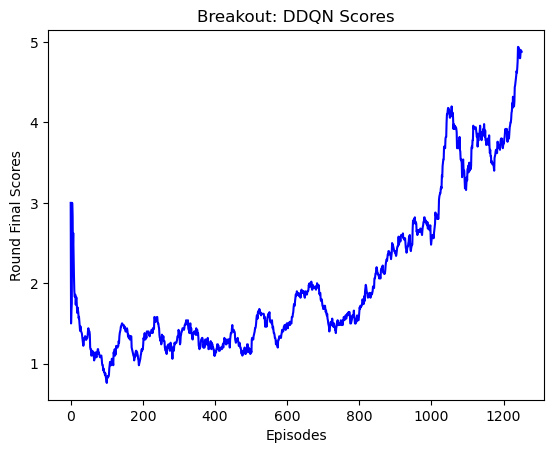

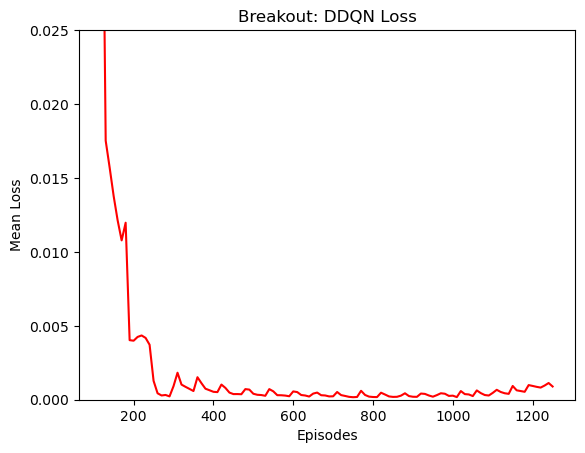

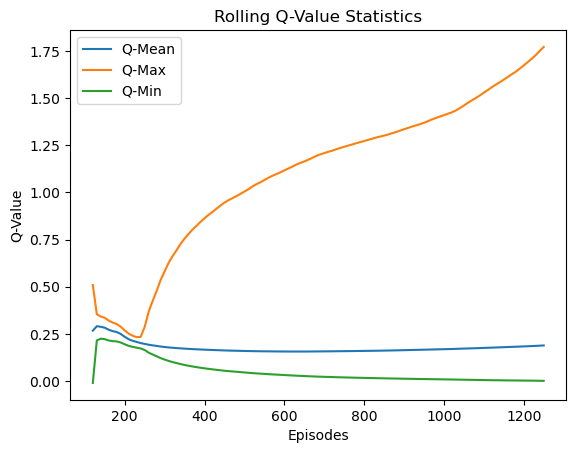

Checkpoint for episode 1250 saved
episode: 1251   frame: 235842   score: 2.0   memory length: 200000   epsilon: 0.10391   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 4.88 mean loss: 0.00096
episode: 1252   frame: 236087   score: 3.0   memory length: 200000   epsilon: 0.1037   train inerval: 4   steps: 245   lr: 0.0001   reward MA: 4.84 mean loss: 0.00088
episode: 1253   frame: 236265   score: 2.0   memory length: 200000   epsilon: 0.10349   train inerval: 4   steps: 178   lr: 0.0001   reward MA: 4.8 mean loss: 0.00097
episode: 1254   frame: 236699   score: 11.0   memory length: 200000   epsilon: 0.10328   train inerval: 4   steps: 434   lr: 0.0001   reward MA: 4.8 mean loss: 0.0009
episode: 1255   frame: 237055   score: 7.0   memory length: 200000   epsilon: 0.10308   train inerval: 4   steps: 356   lr: 0.0001   reward MA: 4.84 mean loss: 0.00086
episode: 1256   frame: 237296   score: 7.0   memory length: 200000   epsilon: 0.10287   train inerval: 4   steps: 241   lr: 0.000

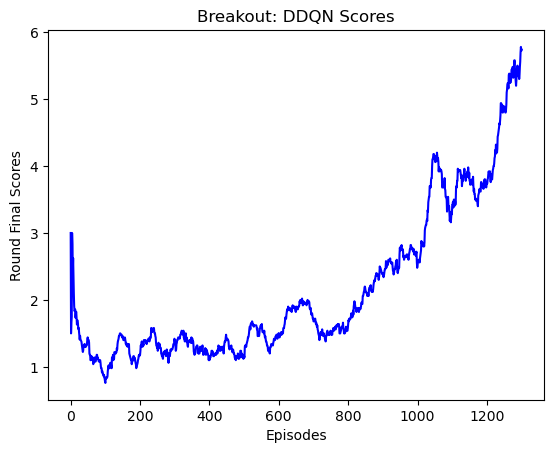

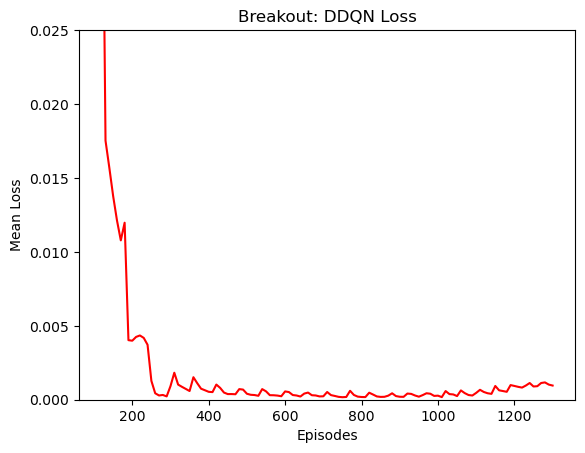

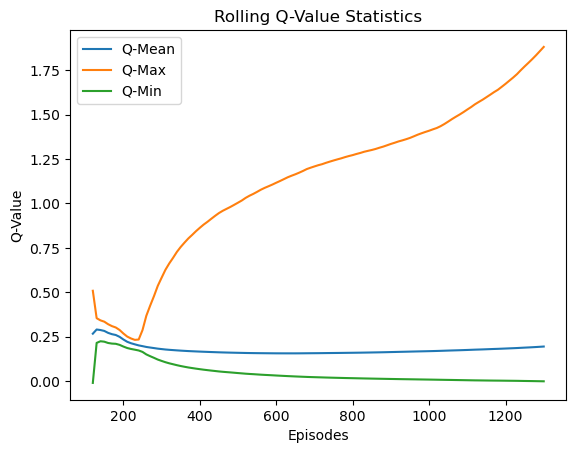

episode: 1301   frame: 249430   score: 6.0   memory length: 200000   epsilon: 0.09401   train inerval: 4   steps: 350   lr: 0.0001   reward MA: 5.82 mean loss: 0.00098
episode: 1302   frame: 249690   score: 4.0   memory length: 200000   epsilon: 0.09382   train inerval: 4   steps: 260   lr: 0.0001   reward MA: 5.84 mean loss: 0.00097
episode: 1303   frame: 249899   score: 3.0   memory length: 200000   epsilon: 0.09363   train inerval: 4   steps: 209   lr: 0.0001   reward MA: 5.86 mean loss: 0.0009
Target network updated at frame:  250000
episode: 1304   frame: 250104   score: 3.0   memory length: 200000   epsilon: 0.09345   train inerval: 4   steps: 205   lr: 0.0001   reward MA: 5.7 mean loss: 0.00109
episode: 1305   frame: 250378   score: 4.0   memory length: 200000   epsilon: 0.09326   train inerval: 4   steps: 274   lr: 0.0001   reward MA: 5.64 mean loss: 0.00211
episode: 1306   frame: 250731   score: 7.0   memory length: 200000   epsilon: 0.09307   train inerval: 4   steps: 353   l

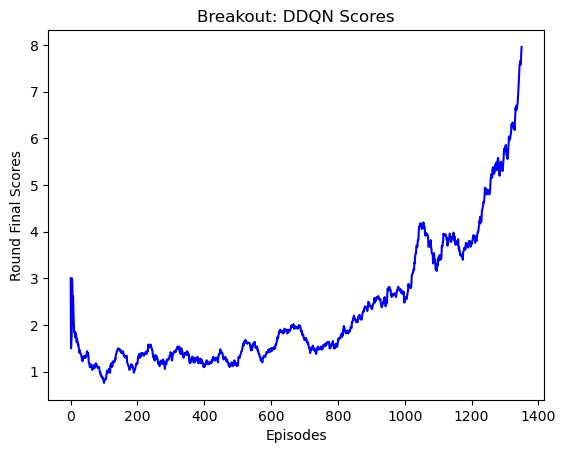

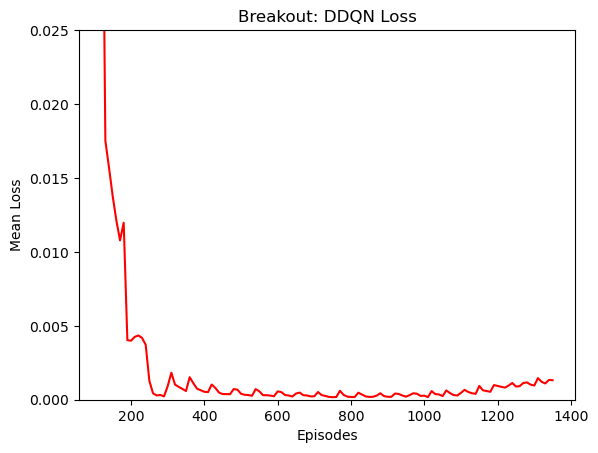

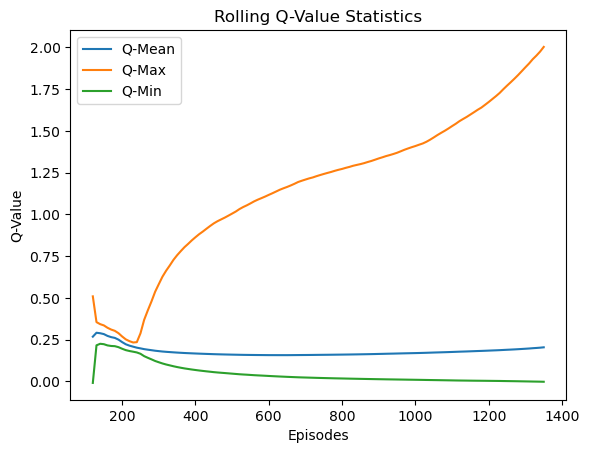

episode: 1351   frame: 265122   score: 16.0   memory length: 200000   epsilon: 0.08505   train inerval: 4   steps: 317   lr: 0.0001   reward MA: 8.16 mean loss: 0.00127
episode: 1352   frame: 265363   score: 7.0   memory length: 200000   epsilon: 0.08488   train inerval: 4   steps: 241   lr: 0.0001   reward MA: 8.22 mean loss: 0.00128
episode: 1353   frame: 265675   score: 12.0   memory length: 200000   epsilon: 0.08471   train inerval: 4   steps: 312   lr: 0.0001   reward MA: 8.4 mean loss: 0.00117
episode: 1354   frame: 265997   score: 9.0   memory length: 200000   epsilon: 0.08455   train inerval: 4   steps: 322   lr: 0.0001   reward MA: 8.52 mean loss: 0.00117
episode: 1355   frame: 266303   score: 5.0   memory length: 200000   epsilon: 0.08438   train inerval: 4   steps: 306   lr: 0.0001   reward MA: 8.54 mean loss: 0.0014
episode: 1356   frame: 266587   score: 5.0   memory length: 200000   epsilon: 0.08421   train inerval: 4   steps: 284   lr: 0.0001   reward MA: 8.5 mean loss: 0

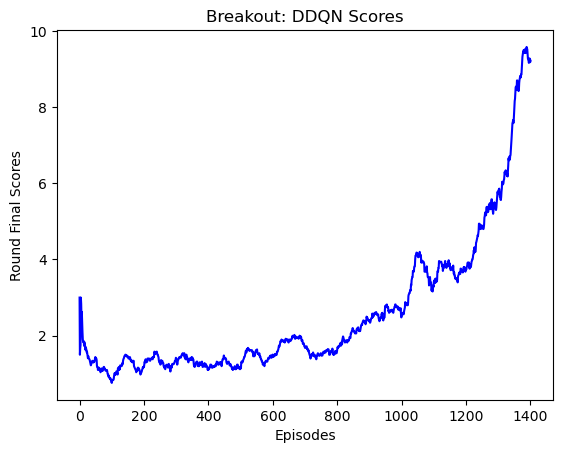

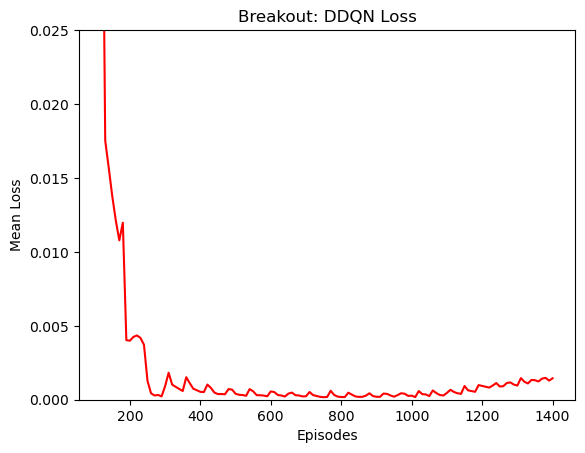

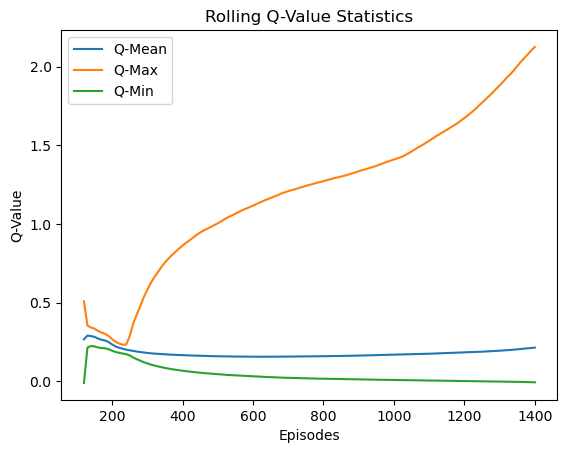

episode: 1401   frame: 281501   score: 20.0   memory length: 200000   epsilon: 0.07695   train inerval: 4   steps: 664   lr: 0.0001   reward MA: 9.3 mean loss: 0.00179
episode: 1402   frame: 281825   score: 9.0   memory length: 200000   epsilon: 0.0768   train inerval: 4   steps: 324   lr: 0.0001   reward MA: 9.34 mean loss: 0.00176
episode: 1403   frame: 282244   score: 18.0   memory length: 200000   epsilon: 0.07665   train inerval: 4   steps: 419   lr: 0.0001   reward MA: 9.46 mean loss: 0.00156
episode: 1404   frame: 282670   score: 12.0   memory length: 200000   epsilon: 0.07649   train inerval: 4   steps: 426   lr: 0.0001   reward MA: 9.52 mean loss: 0.00149
episode: 1405   frame: 283159   score: 14.0   memory length: 200000   epsilon: 0.07634   train inerval: 4   steps: 489   lr: 0.0001   reward MA: 9.7 mean loss: 0.00163
episode: 1406   frame: 283726   score: 16.0   memory length: 200000   epsilon: 0.07619   train inerval: 4   steps: 567   lr: 0.0001   reward MA: 9.92 mean loss

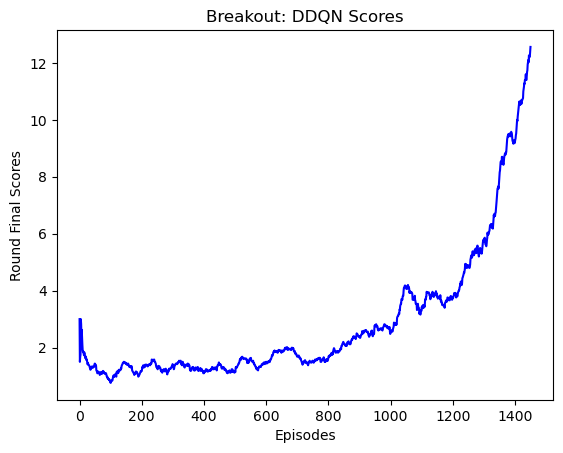

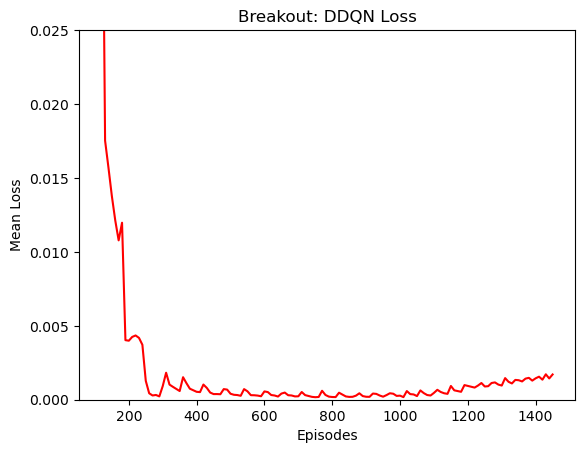

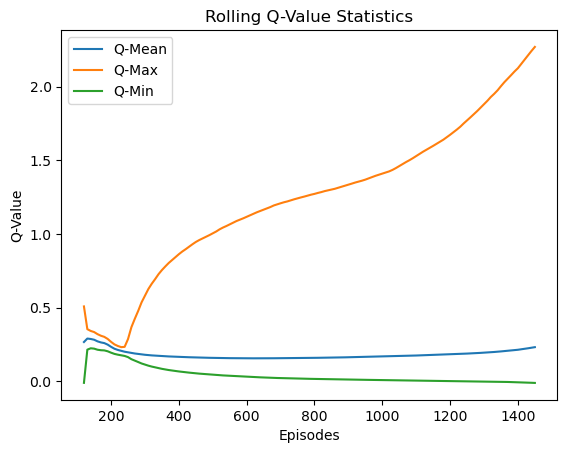

episode: 1451   frame: 302902   score: 22.0   memory length: 200000   epsilon: 0.06962   train inerval: 4   steps: 625   lr: 0.0001   reward MA: 12.6 mean loss: 0.00162
episode: 1452   frame: 303420   score: 14.0   memory length: 200000   epsilon: 0.06948   train inerval: 4   steps: 518   lr: 0.0001   reward MA: 12.7 mean loss: 0.00163
episode: 1453   frame: 303740   score: 16.0   memory length: 200000   epsilon: 0.06934   train inerval: 4   steps: 320   lr: 0.0001   reward MA: 12.66 mean loss: 0.00165
episode: 1454   frame: 304105   score: 14.0   memory length: 200000   epsilon: 0.06921   train inerval: 4   steps: 365   lr: 0.0001   reward MA: 12.7 mean loss: 0.00171
episode: 1455   frame: 304500   score: 18.0   memory length: 200000   epsilon: 0.06907   train inerval: 4   steps: 395   lr: 0.0001   reward MA: 12.78 mean loss: 0.00163
episode: 1456   frame: 304762   score: 11.0   memory length: 200000   epsilon: 0.06893   train inerval: 4   steps: 262   lr: 0.0001   reward MA: 12.68 me

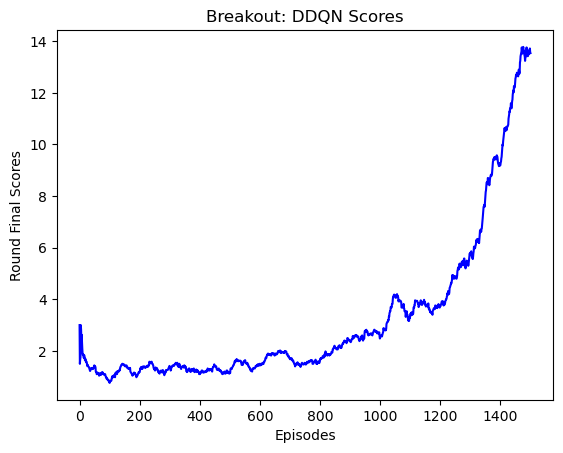

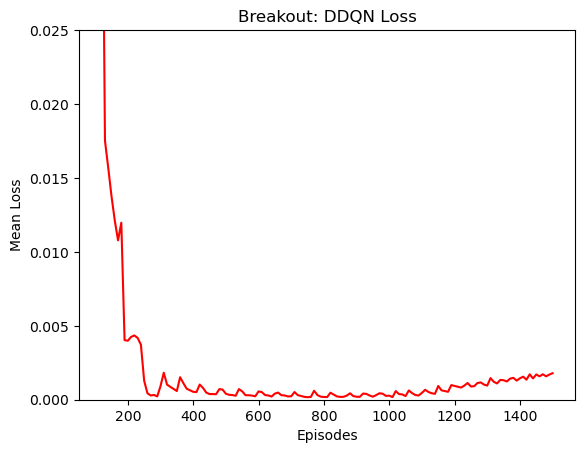

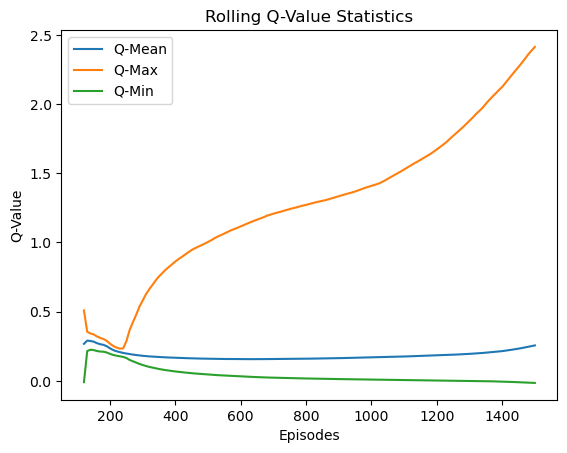

Checkpoint for episode 1500 saved
episode: 1501   frame: 326177   score: 21.0   memory length: 200000   epsilon: 0.06299   train inerval: 4   steps: 492   lr: 5e-05   reward MA: 13.52 mean loss: 0.00167
episode: 1502   frame: 326859   score: 18.0   memory length: 200000   epsilon: 0.06286   train inerval: 4   steps: 682   lr: 5e-05   reward MA: 13.6 mean loss: 0.00165
episode: 1503   frame: 327326   score: 13.0   memory length: 200000   epsilon: 0.06274   train inerval: 4   steps: 467   lr: 5e-05   reward MA: 13.54 mean loss: 0.00157
episode: 1504   frame: 327784   score: 9.0   memory length: 200000   epsilon: 0.06261   train inerval: 4   steps: 458   lr: 5e-05   reward MA: 13.44 mean loss: 0.00163
episode: 1505   frame: 328193   score: 12.0   memory length: 200000   epsilon: 0.06249   train inerval: 4   steps: 409   lr: 5e-05   reward MA: 13.32 mean loss: 0.00156
episode: 1506   frame: 328633   score: 9.0   memory length: 200000   epsilon: 0.06236   train inerval: 4   steps: 440   lr:

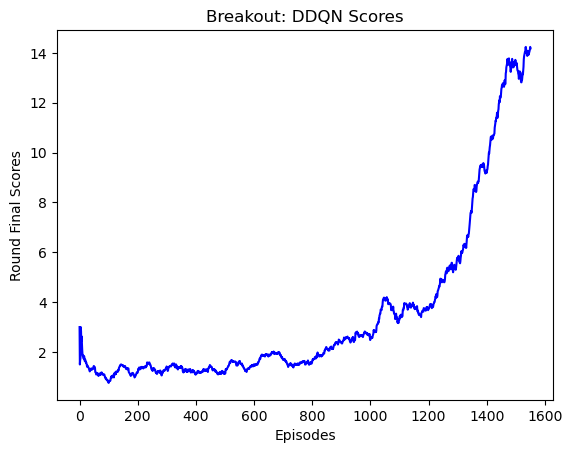

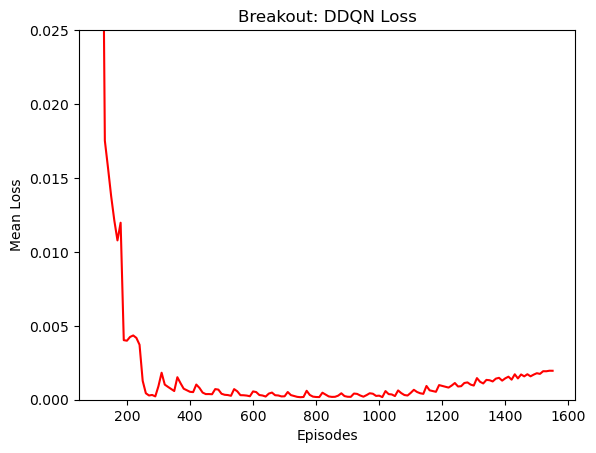

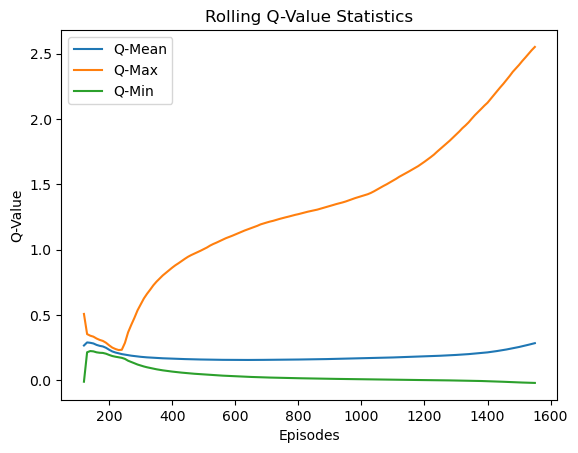

episode: 1551   frame: 352124   score: 16.0   memory length: 200000   epsilon: 0.05699   train inerval: 4   steps: 615   lr: 5e-05   reward MA: 14.08 mean loss: 0.00228
episode: 1552   frame: 352538   score: 8.0   memory length: 200000   epsilon: 0.05688   train inerval: 4   steps: 414   lr: 5e-05   reward MA: 13.88 mean loss: 0.0022
episode: 1553   frame: 352967   score: 8.0   memory length: 200000   epsilon: 0.05676   train inerval: 4   steps: 429   lr: 5e-05   reward MA: 13.78 mean loss: 0.00201
episode: 1554   frame: 353526   score: 13.0   memory length: 200000   epsilon: 0.05665   train inerval: 4   steps: 559   lr: 5e-05   reward MA: 13.86 mean loss: 0.00201
episode: 1555   frame: 354103   score: 13.0   memory length: 200000   epsilon: 0.05654   train inerval: 4   steps: 577   lr: 5e-05   reward MA: 13.88 mean loss: 0.002
episode: 1556   frame: 354524   score: 8.0   memory length: 200000   epsilon: 0.05642   train inerval: 4   steps: 421   lr: 5e-05   reward MA: 13.86 mean loss: 

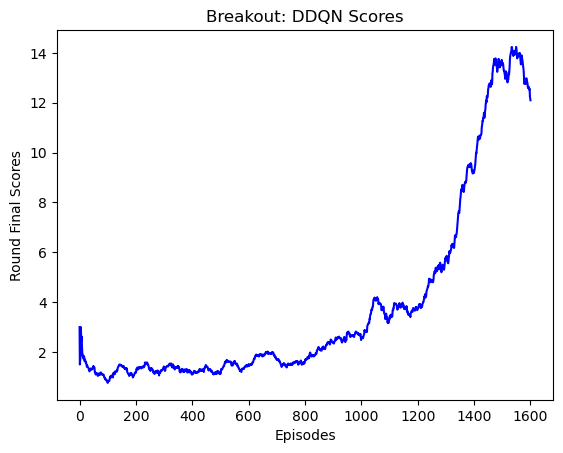

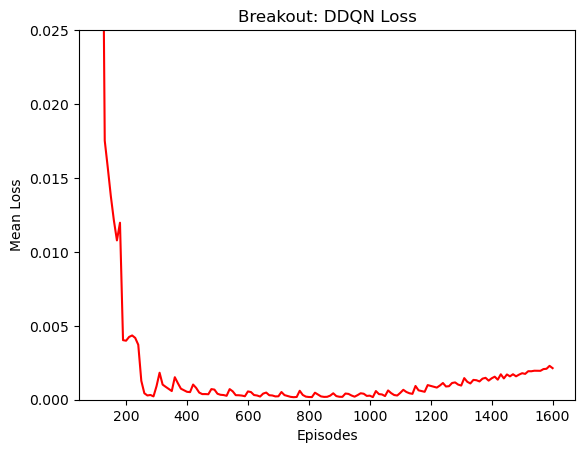

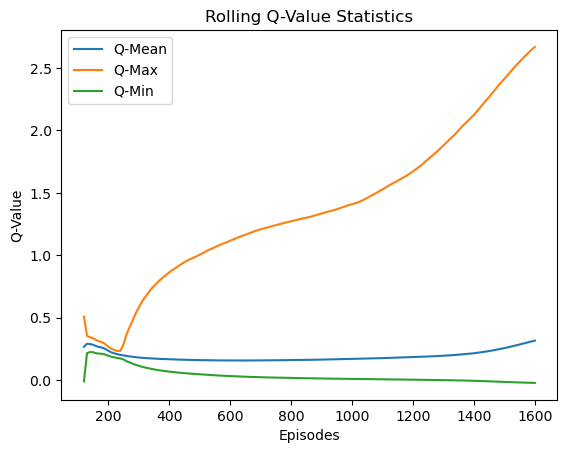

episode: 1601   frame: 377226   score: 7.0   memory length: 200000   epsilon: 0.05156   train inerval: 4   steps: 394   lr: 5e-05   reward MA: 11.92 mean loss: 0.00202
episode: 1602   frame: 377698   score: 14.0   memory length: 200000   epsilon: 0.05146   train inerval: 4   steps: 472   lr: 5e-05   reward MA: 12.04 mean loss: 0.00197
episode: 1603   frame: 378246   score: 11.0   memory length: 200000   epsilon: 0.05136   train inerval: 4   steps: 548   lr: 5e-05   reward MA: 12.1 mean loss: 0.00198
episode: 1604   frame: 378650   score: 11.0   memory length: 200000   epsilon: 0.05125   train inerval: 4   steps: 404   lr: 5e-05   reward MA: 12.06 mean loss: 0.00208
episode: 1605   frame: 379066   score: 9.0   memory length: 200000   epsilon: 0.05115   train inerval: 4   steps: 416   lr: 5e-05   reward MA: 11.98 mean loss: 0.00206
episode: 1606   frame: 379634   score: 11.0   memory length: 200000   epsilon: 0.05105   train inerval: 4   steps: 568   lr: 5e-05   reward MA: 12.04 mean los

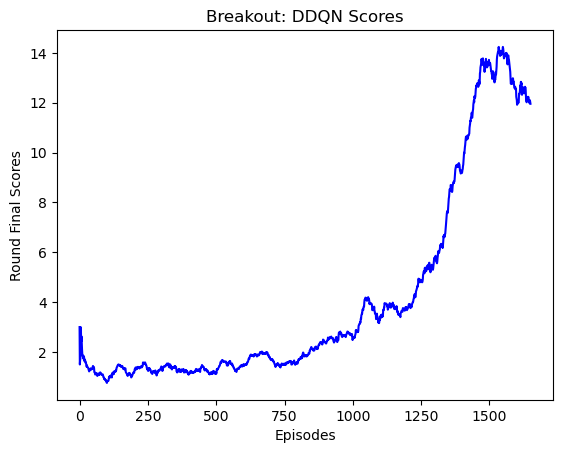

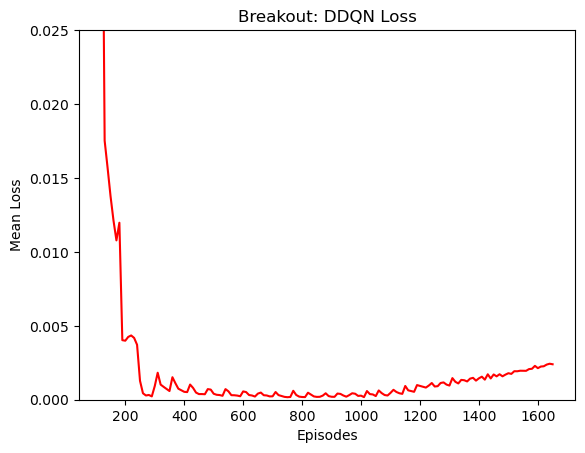

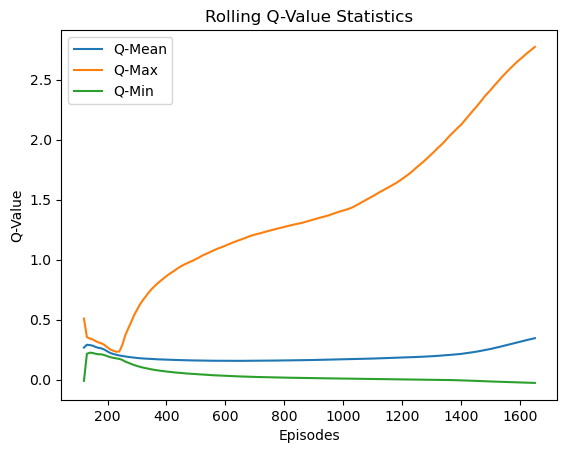

episode: 1651   frame: 401647   score: 18.0   memory length: 200000   epsilon: 0.04665   train inerval: 4   steps: 540   lr: 5e-05   reward MA: 12.18 mean loss: 0.0026
episode: 1652   frame: 402198   score: 12.0   memory length: 200000   epsilon: 0.04656   train inerval: 4   steps: 551   lr: 5e-05   reward MA: 12.14 mean loss: 0.00263
episode: 1653   frame: 402638   score: 9.0   memory length: 200000   epsilon: 0.04646   train inerval: 4   steps: 440   lr: 5e-05   reward MA: 12.1 mean loss: 0.00235
episode: 1654   frame: 403092   score: 8.0   memory length: 200000   epsilon: 0.04637   train inerval: 4   steps: 454   lr: 5e-05   reward MA: 12.04 mean loss: 0.0024
episode: 1655   frame: 403517   score: 8.0   memory length: 200000   epsilon: 0.04628   train inerval: 4   steps: 425   lr: 5e-05   reward MA: 12.02 mean loss: 0.00227
episode: 1656   frame: 403906   score: 18.0   memory length: 200000   epsilon: 0.04619   train inerval: 4   steps: 389   lr: 5e-05   reward MA: 12.16 mean loss: 

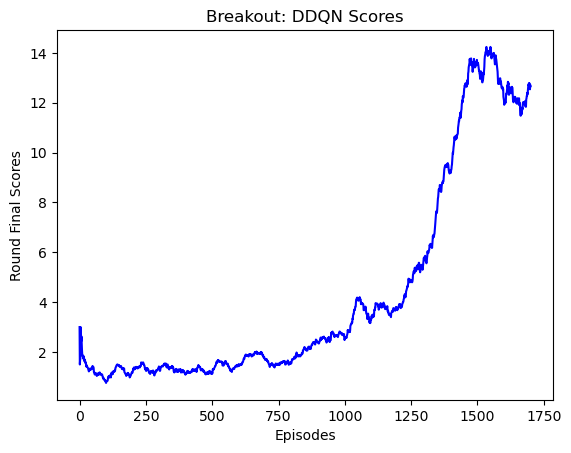

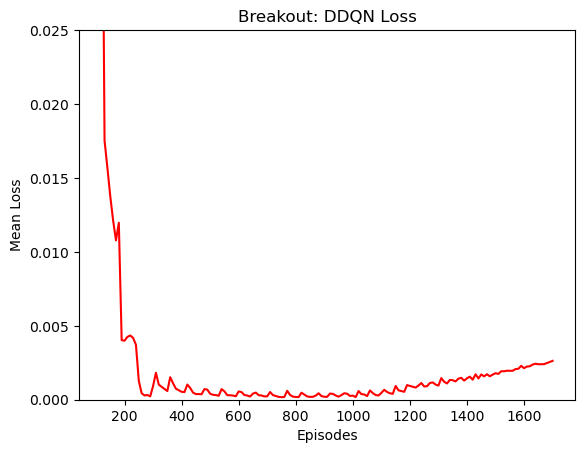

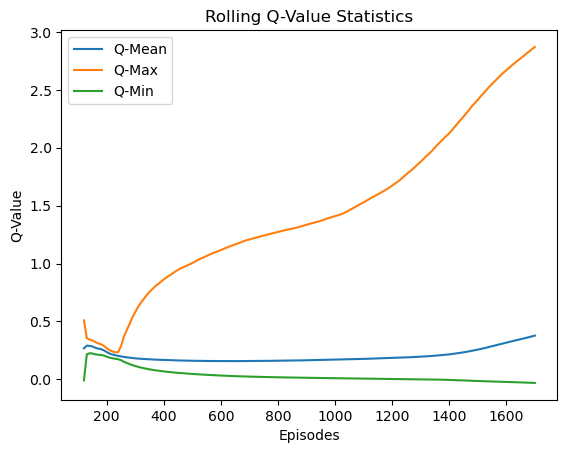

episode: 1701   frame: 426765   score: 16.0   memory length: 200000   epsilon: 0.04221   train inerval: 4   steps: 442   lr: 5e-05   reward MA: 12.62 mean loss: 0.00249
episode: 1702   frame: 427274   score: 13.0   memory length: 200000   epsilon: 0.04212   train inerval: 4   steps: 509   lr: 5e-05   reward MA: 12.64 mean loss: 0.00276
episode: 1703   frame: 427655   score: 14.0   memory length: 200000   epsilon: 0.04204   train inerval: 4   steps: 381   lr: 5e-05   reward MA: 12.74 mean loss: 0.00262
episode: 1704   frame: 428118   score: 12.0   memory length: 200000   epsilon: 0.04195   train inerval: 4   steps: 463   lr: 5e-05   reward MA: 12.82 mean loss: 0.00269
episode: 1705   frame: 428648   score: 15.0   memory length: 200000   epsilon: 0.04187   train inerval: 4   steps: 530   lr: 5e-05   reward MA: 12.96 mean loss: 0.00273
episode: 1706   frame: 429148   score: 9.0   memory length: 200000   epsilon: 0.04179   train inerval: 4   steps: 500   lr: 5e-05   reward MA: 12.78 mean l

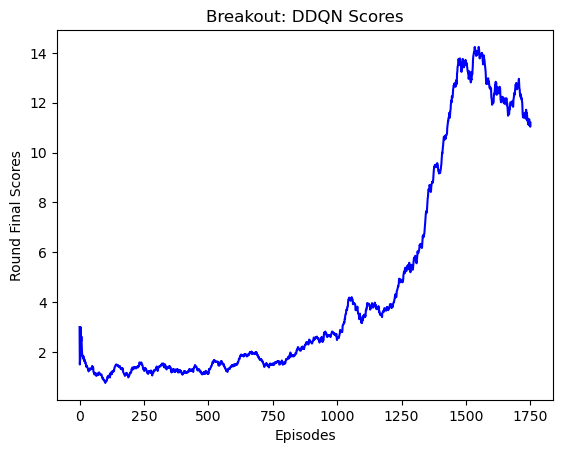

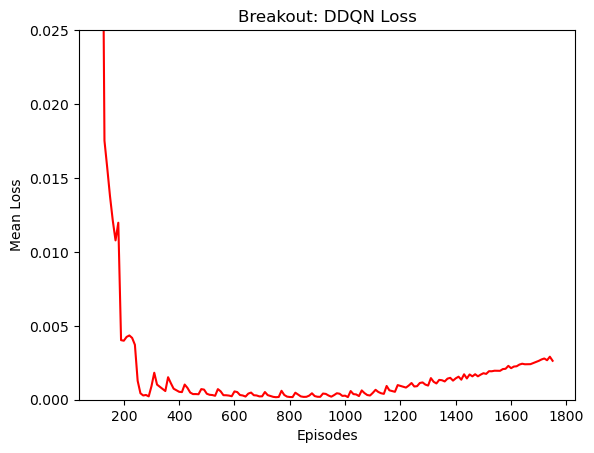

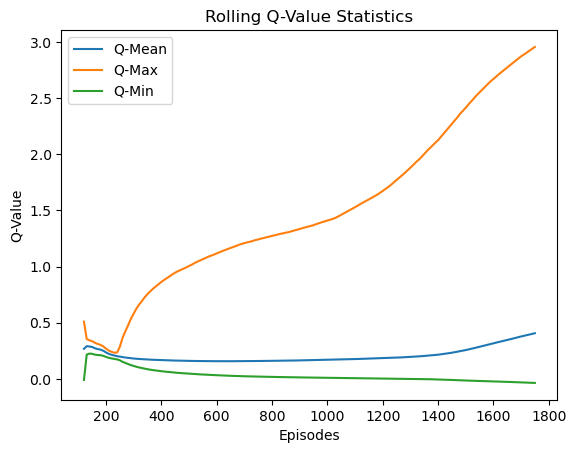

Checkpoint for episode 1750 saved
episode: 1751   frame: 450485   score: 8.0   memory length: 200000   epsilon: 0.18346   train inerval: 4   steps: 414   lr: 5e-05   reward MA: 11.04 mean loss: 0.00268
episode: 1752   frame: 450751   score: 5.0   memory length: 200000   epsilon: 0.18309   train inerval: 4   steps: 266   lr: 5e-05   reward MA: 10.88 mean loss: 0.00362
episode: 1753   frame: 451004   score: 4.0   memory length: 200000   epsilon: 0.18272   train inerval: 4   steps: 253   lr: 5e-05   reward MA: 10.68 mean loss: 0.00307
episode: 1754   frame: 451632   score: 16.0   memory length: 200000   epsilon: 0.18236   train inerval: 4   steps: 628   lr: 5e-05   reward MA: 10.76 mean loss: 0.00309
episode: 1755   frame: 452013   score: 14.0   memory length: 200000   epsilon: 0.18199   train inerval: 4   steps: 381   lr: 5e-05   reward MA: 10.74 mean loss: 0.00323
episode: 1756   frame: 452345   score: 6.0   memory length: 200000   epsilon: 0.18163   train inerval: 4   steps: 332   lr: 

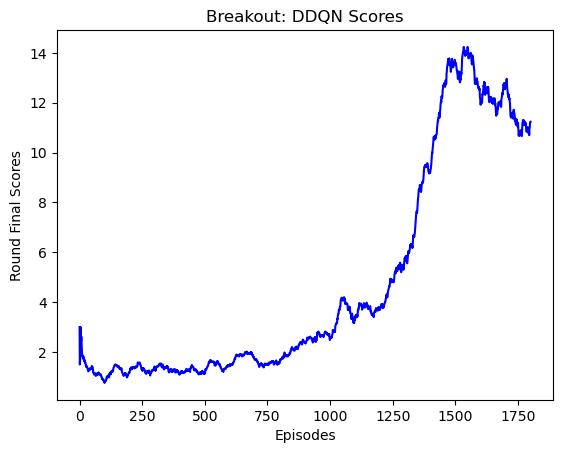

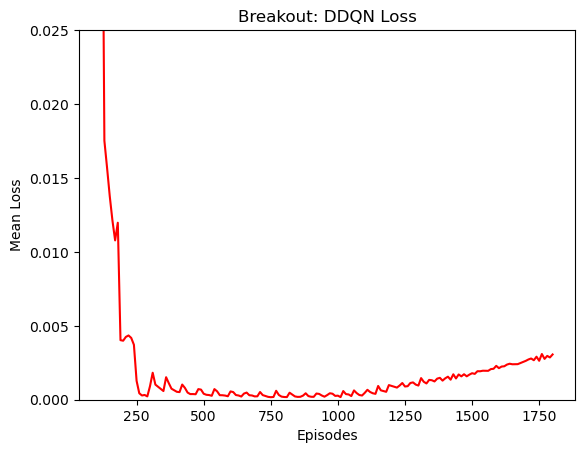

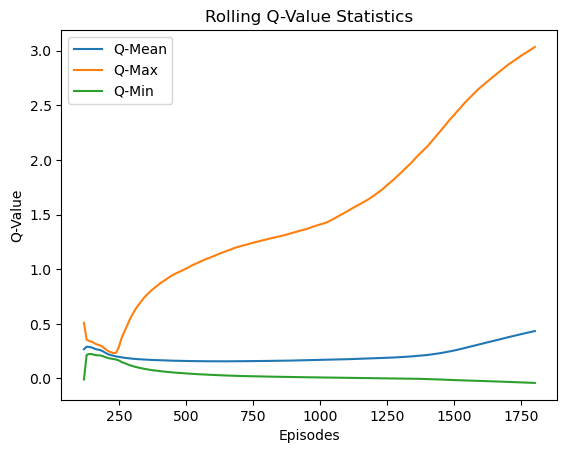

episode: 1801   frame: 473298   score: 16.0   memory length: 200000   epsilon: 0.16598   train inerval: 4   steps: 637   lr: 5e-05   reward MA: 11.4 mean loss: 0.00321
episode: 1802   frame: 473663   score: 14.0   memory length: 200000   epsilon: 0.16565   train inerval: 4   steps: 365   lr: 5e-05   reward MA: 11.58 mean loss: 0.0031
episode: 1803   frame: 474192   score: 11.0   memory length: 200000   epsilon: 0.16532   train inerval: 4   steps: 529   lr: 5e-05   reward MA: 11.72 mean loss: 0.00298
episode: 1804   frame: 474591   score: 12.0   memory length: 200000   epsilon: 0.16499   train inerval: 4   steps: 399   lr: 5e-05   reward MA: 11.64 mean loss: 0.00304
episode: 1805   frame: 474900   score: 6.0   memory length: 200000   epsilon: 0.16466   train inerval: 4   steps: 309   lr: 5e-05   reward MA: 11.48 mean loss: 0.00298
episode: 1806   frame: 475353   score: 8.0   memory length: 200000   epsilon: 0.16433   train inerval: 4   steps: 453   lr: 5e-05   reward MA: 11.52 mean loss

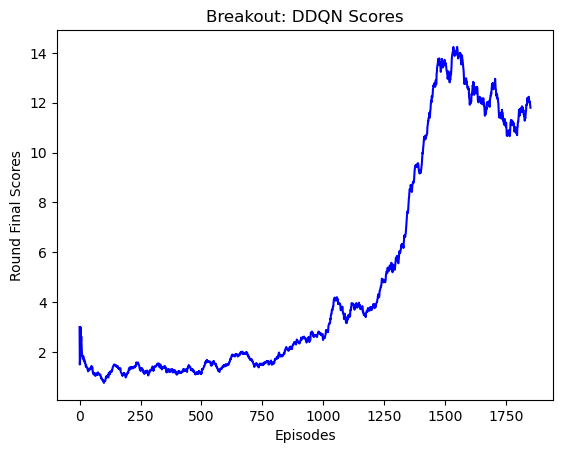

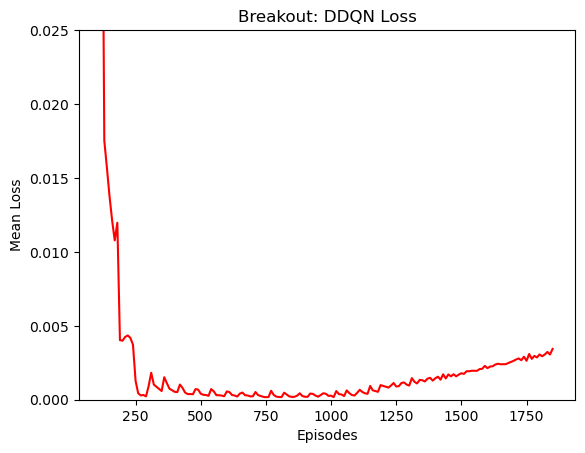

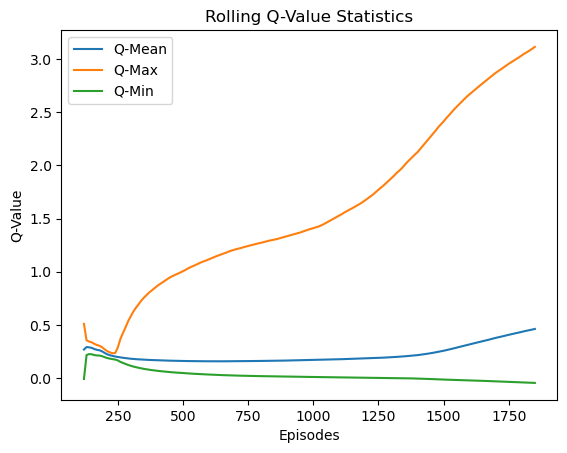

episode: 1851   frame: 495749   score: 21.0   memory length: 200000   epsilon: 0.15017   train inerval: 4   steps: 534   lr: 5e-05   reward MA: 11.9 mean loss: 0.00307
episode: 1852   frame: 496293   score: 12.0   memory length: 200000   epsilon: 0.14987   train inerval: 4   steps: 544   lr: 5e-05   reward MA: 11.86 mean loss: 0.00335
episode: 1853   frame: 496713   score: 15.0   memory length: 200000   epsilon: 0.14957   train inerval: 4   steps: 420   lr: 5e-05   reward MA: 11.94 mean loss: 0.0032
episode: 1854   frame: 497115   score: 11.0   memory length: 200000   epsilon: 0.14927   train inerval: 4   steps: 402   lr: 5e-05   reward MA: 11.92 mean loss: 0.00311
episode: 1855   frame: 497557   score: 20.0   memory length: 200000   epsilon: 0.14897   train inerval: 4   steps: 442   lr: 5e-05   reward MA: 12.2 mean loss: 0.00306
episode: 1856   frame: 498036   score: 11.0   memory length: 200000   epsilon: 0.14868   train inerval: 4   steps: 479   lr: 5e-05   reward MA: 12.26 mean los

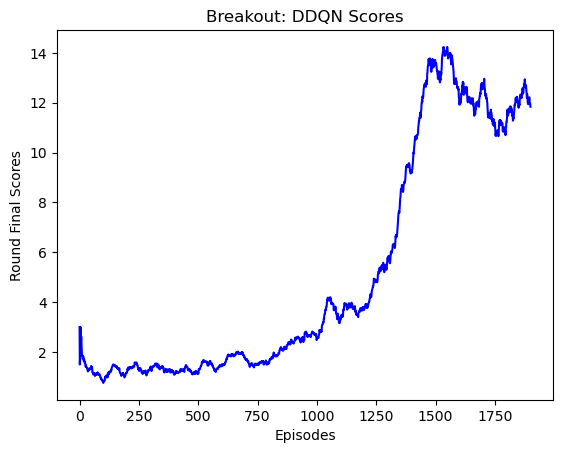

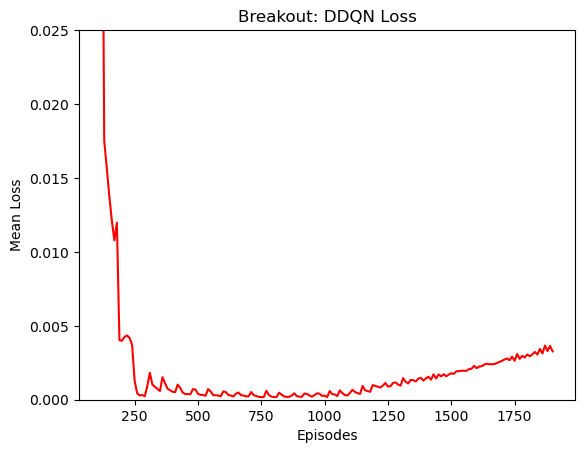

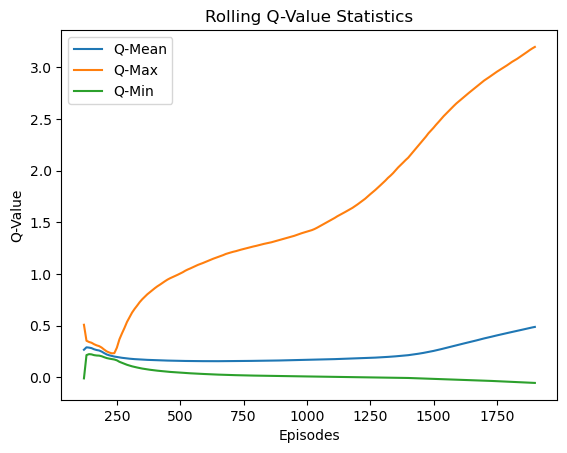

episode: 1901   frame: 518660   score: 10.0   memory length: 200000   epsilon: 0.13587   train inerval: 4   steps: 454   lr: 5e-05   reward MA: 11.62 mean loss: 0.00311
episode: 1902   frame: 519139   score: 10.0   memory length: 200000   epsilon: 0.1356   train inerval: 4   steps: 479   lr: 5e-05   reward MA: 11.58 mean loss: 0.00312
episode: 1903   frame: 519709   score: 13.0   memory length: 200000   epsilon: 0.13533   train inerval: 4   steps: 570   lr: 5e-05   reward MA: 11.54 mean loss: 0.00308
Target network updated at frame:  520000
episode: 1904   frame: 520066   score: 10.0   memory length: 200000   epsilon: 0.13505   train inerval: 4   steps: 357   lr: 5e-05   reward MA: 11.52 mean loss: 0.00304
episode: 1905   frame: 520436   score: 10.0   memory length: 200000   epsilon: 0.13478   train inerval: 4   steps: 370   lr: 5e-05   reward MA: 11.32 mean loss: 0.00334
episode: 1906   frame: 520783   score: 7.0   memory length: 200000   epsilon: 0.13452   train inerval: 4   steps: 3

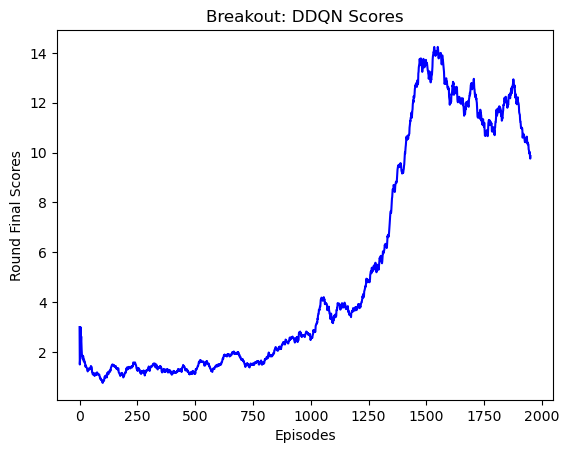

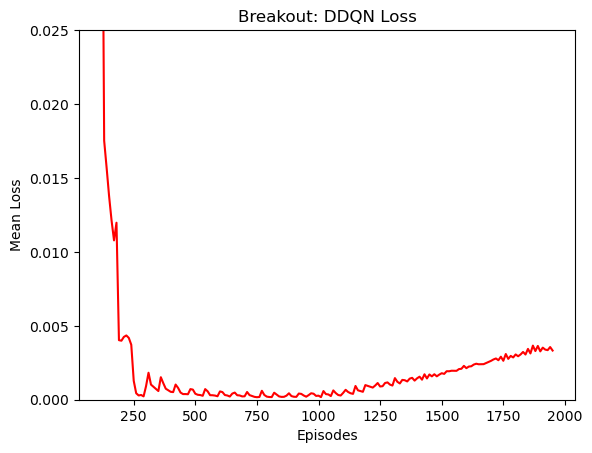

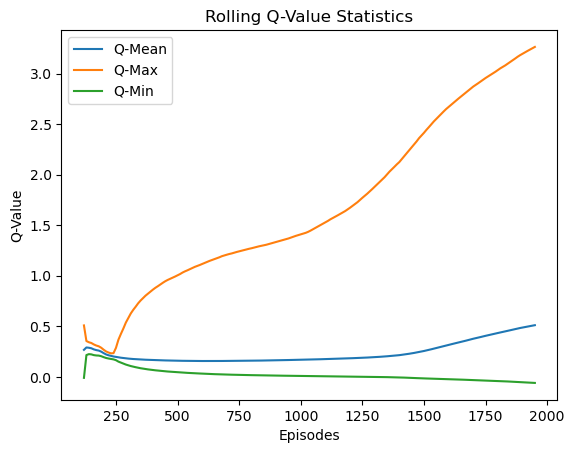

episode: 1951   frame: 539585   score: 9.0   memory length: 200000   epsilon: 0.2682   train inerval: 4   steps: 454   lr: 5e-05   reward MA: 9.84 mean loss: 0.00328
episode: 1952   frame: 539920   score: 6.0   memory length: 200000   epsilon: 0.26766   train inerval: 4   steps: 335   lr: 5e-05   reward MA: 9.76 mean loss: 0.00322
Target network updated at frame:  540000
episode: 1953   frame: 540343   score: 8.0   memory length: 200000   epsilon: 0.26713   train inerval: 4   steps: 423   lr: 5e-05   reward MA: 9.66 mean loss: 0.00316
episode: 1954   frame: 540822   score: 13.0   memory length: 200000   epsilon: 0.26659   train inerval: 4   steps: 479   lr: 5e-05   reward MA: 9.72 mean loss: 0.00405
episode: 1955   frame: 541246   score: 11.0   memory length: 200000   epsilon: 0.26606   train inerval: 4   steps: 424   lr: 5e-05   reward MA: 9.74 mean loss: 0.00408
episode: 1956   frame: 541710   score: 9.0   memory length: 200000   epsilon: 0.26553   train inerval: 4   steps: 464   lr:

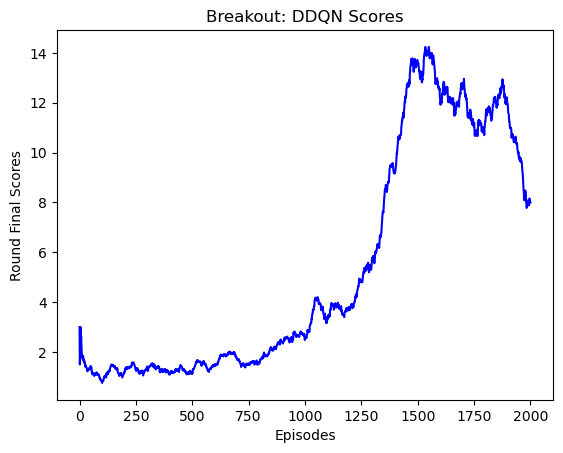

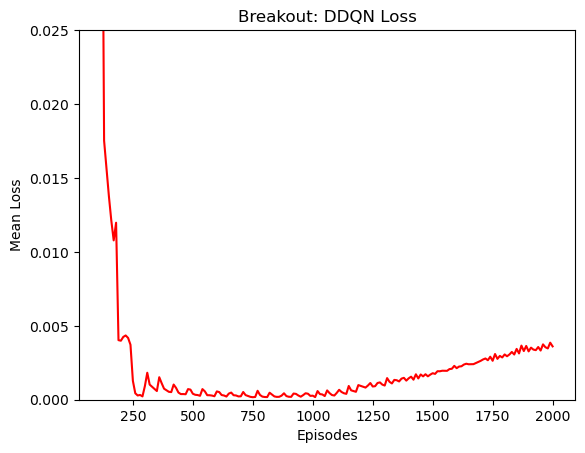

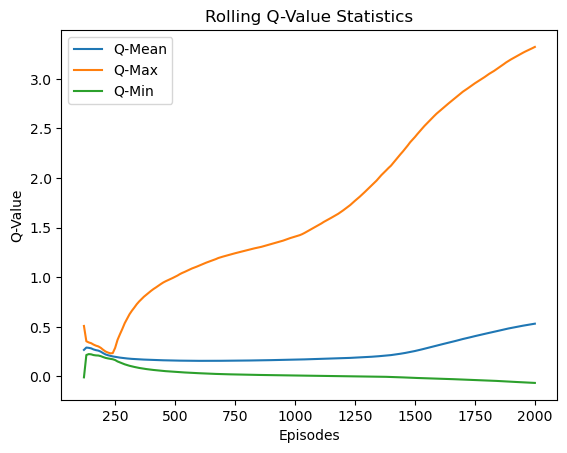

Checkpoint for episode 2000 saved
episode: 2001   frame: 558791   score: 10.0   memory length: 200000   epsilon: 0.24265   train inerval: 4   steps: 505   lr: 5e-05   reward MA: 8.02 mean loss: 0.00356
episode: 2002   frame: 559294   score: 13.0   memory length: 200000   epsilon: 0.24217   train inerval: 4   steps: 503   lr: 5e-05   reward MA: 8.16 mean loss: 0.00327
episode: 2003   frame: 559683   score: 7.0   memory length: 200000   epsilon: 0.24168   train inerval: 4   steps: 389   lr: 5e-05   reward MA: 8.14 mean loss: 0.00352
Target network updated at frame:  560000
episode: 2004   frame: 560226   score: 10.0   memory length: 200000   epsilon: 0.2412   train inerval: 4   steps: 543   lr: 5e-05   reward MA: 8.08 mean loss: 0.0035
episode: 2005   frame: 560498   score: 4.0   memory length: 200000   epsilon: 0.24072   train inerval: 4   steps: 272   lr: 5e-05   reward MA: 7.94 mean loss: 0.00401
episode: 2006   frame: 560745   score: 3.0   memory length: 200000   epsilon: 0.24023   t

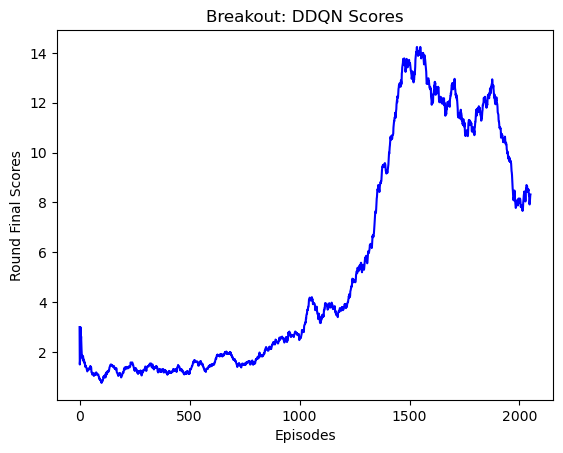

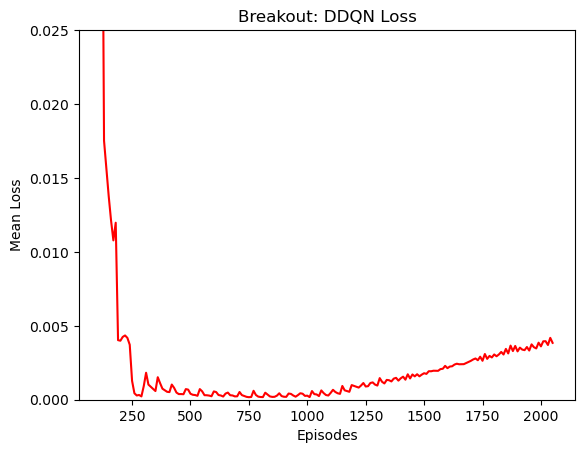

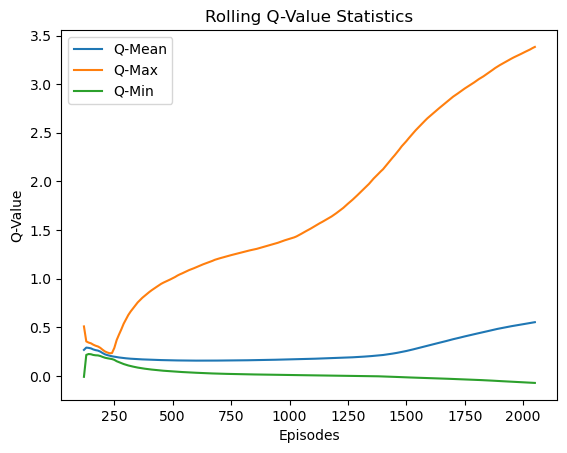

episode: 2051   frame: 578805   score: 8.0   memory length: 200000   epsilon: 0.21954   train inerval: 4   steps: 397   lr: 5e-05   reward MA: 8.28 mean loss: 0.00381
episode: 2052   frame: 579202   score: 7.0   memory length: 200000   epsilon: 0.2191   train inerval: 4   steps: 397   lr: 5e-05   reward MA: 8.16 mean loss: 0.00363
episode: 2053   frame: 579629   score: 8.0   memory length: 200000   epsilon: 0.21866   train inerval: 4   steps: 427   lr: 5e-05   reward MA: 8.18 mean loss: 0.00353
Target network updated at frame:  580000
episode: 2054   frame: 580156   score: 18.0   memory length: 200000   epsilon: 0.21822   train inerval: 4   steps: 527   lr: 5e-05   reward MA: 8.34 mean loss: 0.0037
episode: 2055   frame: 580510   score: 6.0   memory length: 200000   epsilon: 0.21779   train inerval: 4   steps: 354   lr: 5e-05   reward MA: 8.38 mean loss: 0.00412
episode: 2056   frame: 581193   score: 14.0   memory length: 200000   epsilon: 0.21735   train inerval: 4   steps: 683   lr: 

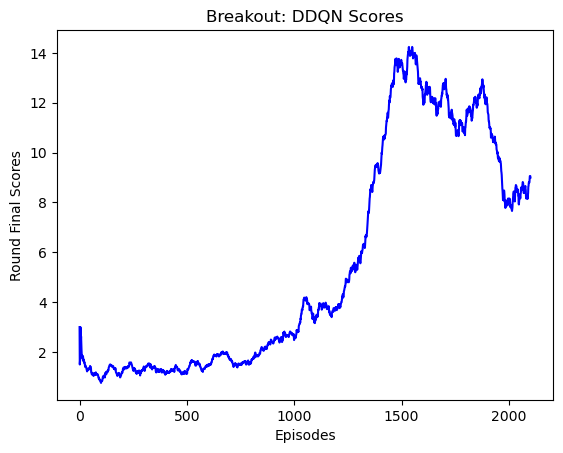

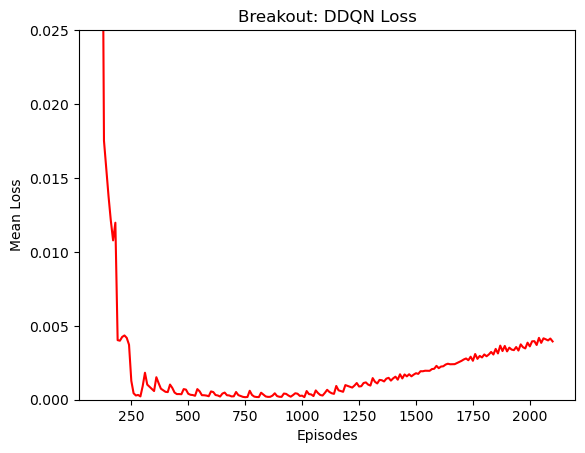

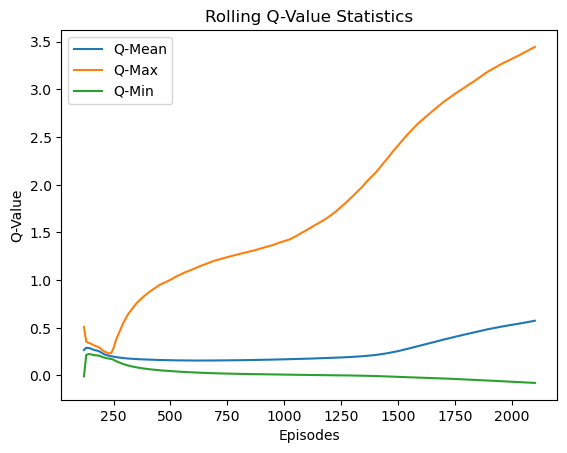

Target network updated at frame:  600000
episode: 2101   frame: 600256   score: 9.0   memory length: 200000   epsilon: 0.19863   train inerval: 4   steps: 469   lr: 5e-05   reward MA: 9.02 mean loss: 0.00386
episode: 2102   frame: 600700   score: 8.0   memory length: 200000   epsilon: 0.19823   train inerval: 4   steps: 444   lr: 5e-05   reward MA: 9.04 mean loss: 0.00459
episode: 2103   frame: 600976   score: 4.0   memory length: 200000   epsilon: 0.19783   train inerval: 4   steps: 276   lr: 5e-05   reward MA: 8.96 mean loss: 0.00496
episode: 2104   frame: 601389   score: 12.0   memory length: 200000   epsilon: 0.19744   train inerval: 4   steps: 413   lr: 5e-05   reward MA: 8.84 mean loss: 0.0044
episode: 2105   frame: 601858   score: 10.0   memory length: 200000   epsilon: 0.19704   train inerval: 4   steps: 469   lr: 5e-05   reward MA: 8.92 mean loss: 0.00451
episode: 2106   frame: 602227   score: 7.0   memory length: 200000   epsilon: 0.19665   train inerval: 4   steps: 369   lr:

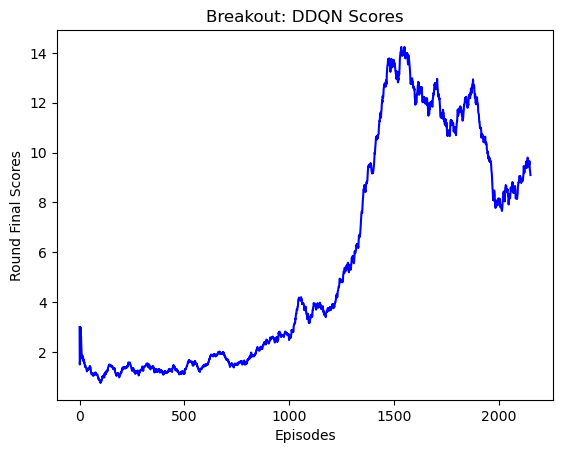

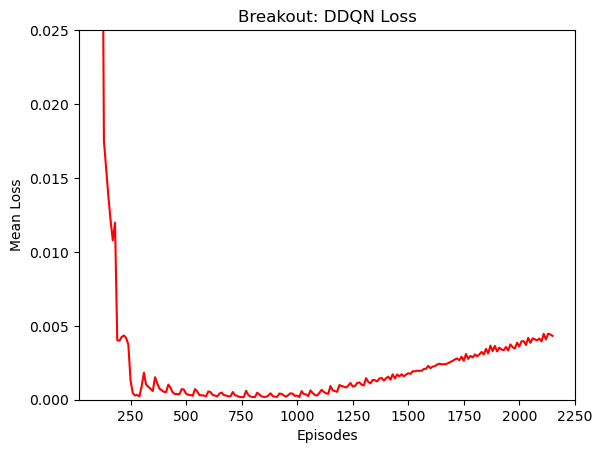

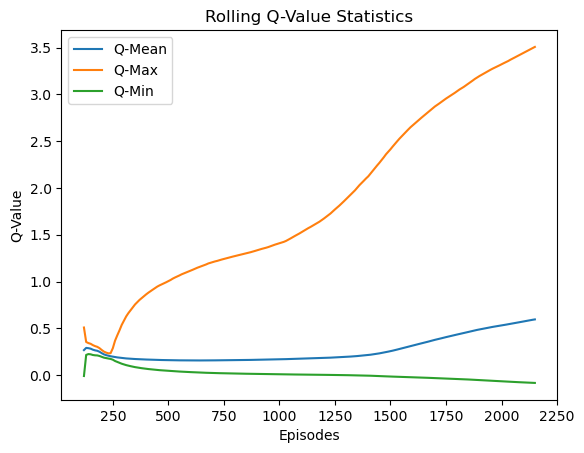

episode: 2151   frame: 620729   score: 7.0   memory length: 200000   epsilon: 0.32498   train inerval: 4   steps: 370   lr: 2.5e-05   reward MA: 9.06 mean loss: 0.00495
episode: 2152   frame: 621088   score: 13.0   memory length: 200000   epsilon: 0.32433   train inerval: 4   steps: 359   lr: 2.5e-05   reward MA: 9.16 mean loss: 0.00462
episode: 2153   frame: 621511   score: 9.0   memory length: 200000   epsilon: 0.32368   train inerval: 4   steps: 423   lr: 2.5e-05   reward MA: 9.26 mean loss: 0.0045
episode: 2154   frame: 622050   score: 17.0   memory length: 200000   epsilon: 0.32303   train inerval: 4   steps: 539   lr: 2.5e-05   reward MA: 9.36 mean loss: 0.00443
episode: 2155   frame: 622500   score: 9.0   memory length: 200000   epsilon: 0.32239   train inerval: 4   steps: 450   lr: 2.5e-05   reward MA: 9.34 mean loss: 0.00433
episode: 2156   frame: 622864   score: 7.0   memory length: 200000   epsilon: 0.32174   train inerval: 4   steps: 364   lr: 2.5e-05   reward MA: 9.34 mean

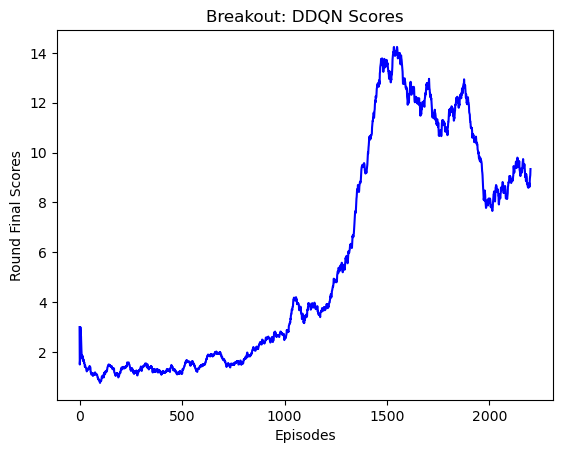

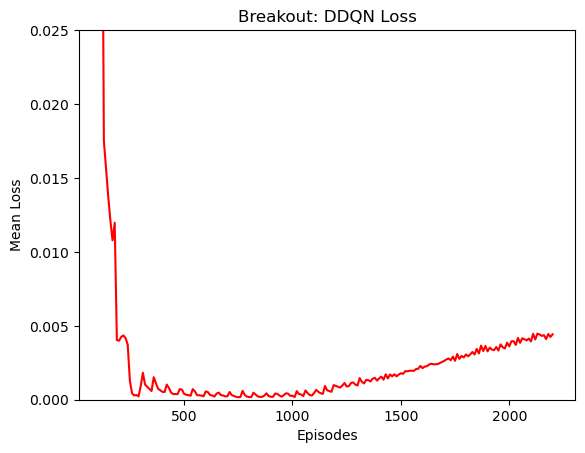

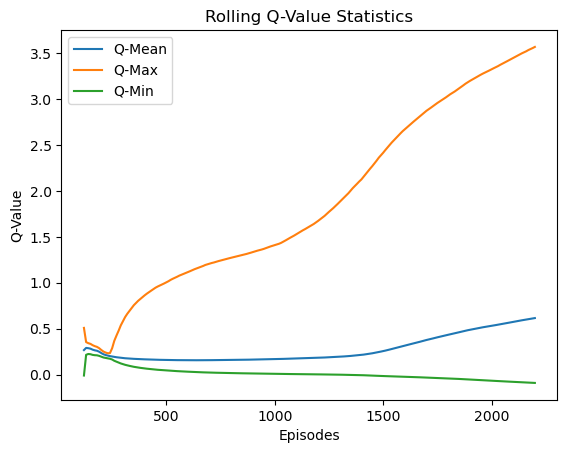

episode: 2201   frame: 642530   score: 8.0   memory length: 200000   epsilon: 0.29402   train inerval: 4   steps: 452   lr: 2.5e-05   reward MA: 9.36 mean loss: 0.00471
episode: 2202   frame: 642952   score: 15.0   memory length: 200000   epsilon: 0.29343   train inerval: 4   steps: 422   lr: 2.5e-05   reward MA: 9.4 mean loss: 0.00466
episode: 2203   frame: 643335   score: 7.0   memory length: 200000   epsilon: 0.29285   train inerval: 4   steps: 383   lr: 2.5e-05   reward MA: 9.36 mean loss: 0.00455
episode: 2204   frame: 643592   score: 4.0   memory length: 200000   epsilon: 0.29226   train inerval: 4   steps: 257   lr: 2.5e-05   reward MA: 9.1 mean loss: 0.00464
episode: 2205   frame: 643931   score: 6.0   memory length: 200000   epsilon: 0.29168   train inerval: 4   steps: 339   lr: 2.5e-05   reward MA: 9.04 mean loss: 0.00455
episode: 2206   frame: 644550   score: 13.0   memory length: 200000   epsilon: 0.29109   train inerval: 4   steps: 619   lr: 2.5e-05   reward MA: 9.16 mean 

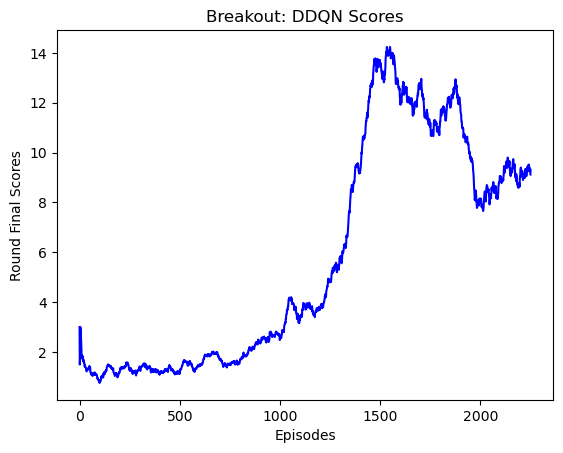

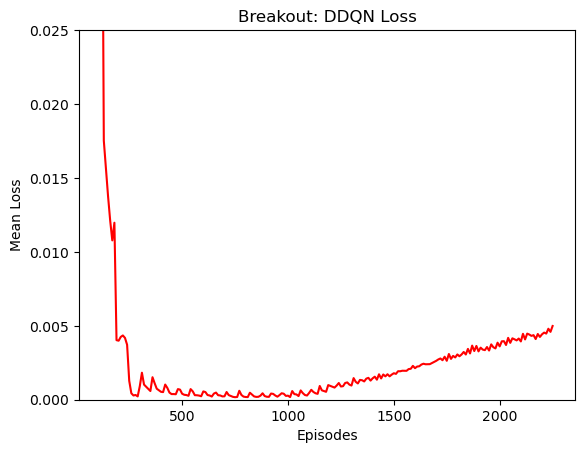

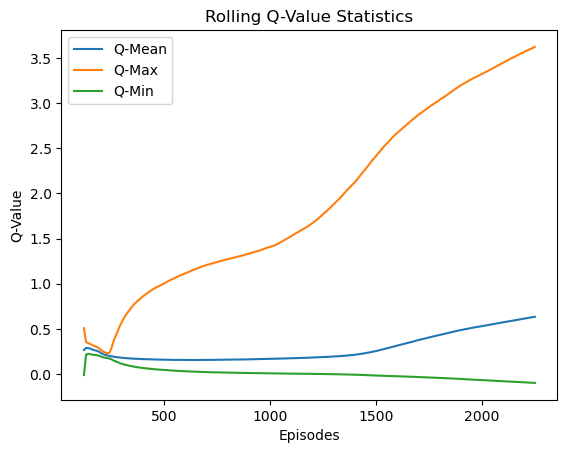

Checkpoint for episode 2250 saved
episode: 2251   frame: 663551   score: 19.0   memory length: 200000   epsilon: 0.26602   train inerval: 4   steps: 625   lr: 2.5e-05   reward MA: 9.34 mean loss: 0.00512
episode: 2252   frame: 664078   score: 14.0   memory length: 200000   epsilon: 0.26548   train inerval: 4   steps: 527   lr: 2.5e-05   reward MA: 9.32 mean loss: 0.00489
episode: 2253   frame: 664576   score: 11.0   memory length: 200000   epsilon: 0.26495   train inerval: 4   steps: 498   lr: 2.5e-05   reward MA: 9.4 mean loss: 0.00493
episode: 2254   frame: 665041   score: 10.0   memory length: 200000   epsilon: 0.26442   train inerval: 4   steps: 465   lr: 2.5e-05   reward MA: 9.52 mean loss: 0.00493
episode: 2255   frame: 665452   score: 8.0   memory length: 200000   epsilon: 0.26389   train inerval: 4   steps: 411   lr: 2.5e-05   reward MA: 9.56 mean loss: 0.00487
episode: 2256   frame: 665982   score: 18.0   memory length: 200000   epsilon: 0.26337   train inerval: 4   steps: 530

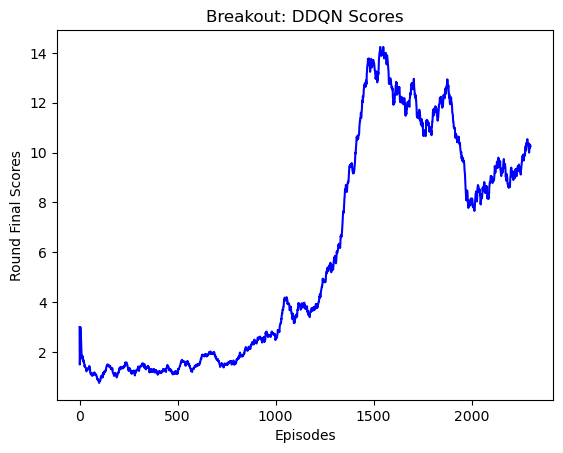

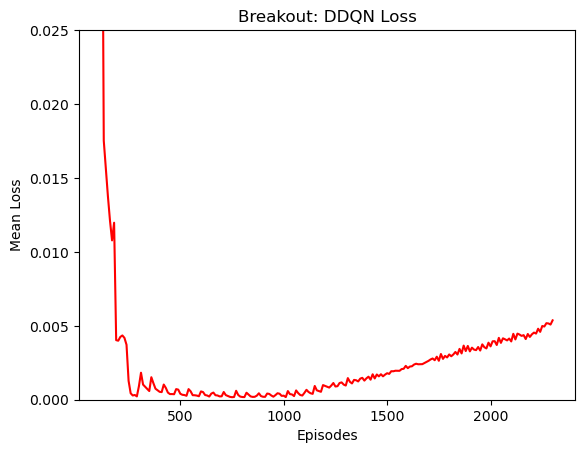

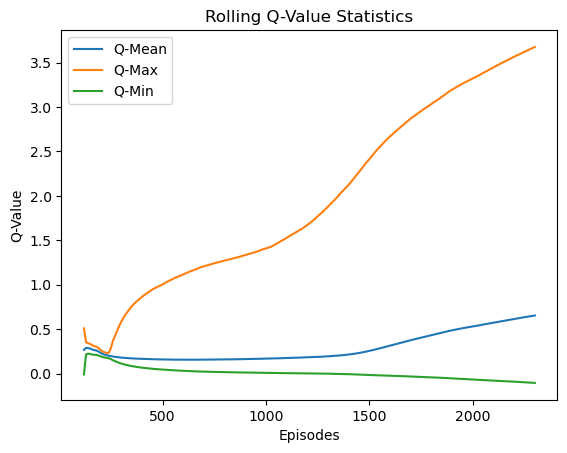

episode: 2301   frame: 685301   score: 14.0   memory length: 200000   epsilon: 0.24068   train inerval: 4   steps: 568   lr: 2.5e-05   reward MA: 10.16 mean loss: 0.00513
episode: 2302   frame: 685650   score: 6.0   memory length: 200000   epsilon: 0.2402   train inerval: 4   steps: 349   lr: 2.5e-05   reward MA: 10.0 mean loss: 0.00525
episode: 2303   frame: 686125   score: 13.0   memory length: 200000   epsilon: 0.23972   train inerval: 4   steps: 475   lr: 2.5e-05   reward MA: 10.04 mean loss: 0.00507
episode: 2304   frame: 686803   score: 19.0   memory length: 200000   epsilon: 0.23924   train inerval: 4   steps: 678   lr: 2.5e-05   reward MA: 10.22 mean loss: 0.0051
episode: 2305   frame: 687177   score: 7.0   memory length: 200000   epsilon: 0.23876   train inerval: 4   steps: 374   lr: 2.5e-05   reward MA: 10.2 mean loss: 0.00519
episode: 2306   frame: 687890   score: 22.0   memory length: 200000   epsilon: 0.23828   train inerval: 4   steps: 713   lr: 2.5e-05   reward MA: 10.28

KeyboardInterrupt: 

In [16]:
from config import *
from IPython.display import clear_output
from gymnasium.wrappers import RecordVideo

# Choose whether to use double DQN
double_dqn = True # set to True if using double DQN agent
if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent


#create fresh environment
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')  # Use equivalent parameters to BreakoutDeterministic-v4

# setup video recording
def video_trigger(_):
    if len(episodes) == 0:
        return False
    else:
        curr_ep = episodes[-1]
        return (curr_ep > 99 and curr_ep % 100 == 0) 

video_path = f"./videos/run{run_num}"
if not os.path.exists(video_path):
    os.makedirs(video_path)
env = RecordVideo(env, video_folder=video_path, episode_trigger=video_trigger)


print(f"Starting run {run_name}")
train_interval = 4
    
evaluation_reward = deque(maxlen=evaluation_reward_length)
rewards, episodes = [], []
best_eval_reward = curr_mean_reward = last_save_reward = 0



#initialize trackers
## LOSS TRACKERS ##
losses_window = deque(maxlen=10)
loss_history = []
episode_losses = []
loss = mean_loss = 0

## Q-VALUE TRACKERS ##
episode_q_means = []
episode_q_maxs = []
episode_q_mins = []
q_mean_window = deque(maxlen=10)
q_max_window = deque(maxlen=10)
q_min_window = deque(maxlen=10)
q_stats_history = {
    'mean': [],
    'max': [],
    'min': [],
    'episode': []
}

# Epsilon Bump Control Variables
plateau_patience = 200
episodes_since_improvement = 0
epsilon_bump = 0.15  # amount to re-increase epsilon
soonest_bump = 600  # episode to start applying epsilon bump


ep_start = 0
training_started_flg = False

print("Instantiating agent")
# agent = Agent(action_size, mem_path)
agent = Agent(action_size)

#########################
#### LOAD CHECKPOINT ####
# metadata = agent.load_checkpoint(run_name, 250)  #Edit episode number
# ep_start = metadata['global_episode']
# frame = metadata['global_frame']
# evaluation_reward = metadata['evaluation_reward']
# rewards = metadata['rewards']    
# episodes = metadata['episodes']
# last_10_ep_losses = metadata['last_10_ep_losses']
# loss_tracker = metadata['loss_tracker']
########################

# check if replay buffer has been preloaded 
# if len(agent.memory) > 0:
#     frame = len(agent.memory)
#     print("Starting at frame ", frame)
# else:
#     frame = 0

frame = 0
start_train_immediate = False

for e in range(ep_start, EPISODES):
    done = False
    score = 0
    episode_losses = []
    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives
    fire_ready = True
    no_reward_steps = 0

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Selet Action (with robust check for FIRE action)
        if fire_ready:
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
        state = next_state
        next_state, reward, terminations, truncations, info = env.step(action)  
        done = truncations or terminations
        
        # Failsafe to force reset if no reward for 4000 steps (prevents agent from getting stuck)
        stuck_limit = 3000
        if no_reward_steps > stuck_limit:
            done = True
            print(f"[WARNING] No reward for {stuck_limit} steps, forcing reset | ", "Episode:", e, "  Frame:", frame, ) 
             
        frame_next_state = get_frame(next_state)
             
        history[4, :, :] = frame_next_state
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life

        if lost_life:
            fire_ready = True

        life = info['lives']
        r = reward
        if r == 0:
            no_reward_steps += 1
        else:
            no_reward_steps = 0 

        # Store the transition in replay buffer if it was not a FIRE action
        if action in TRAINABLE_ACTIONS:
            trainable_index = TRAINABLE_ACTIONS.index(action)
            agent.memory.push(deepcopy(frame_next_state), trainable_index, r, lost_life)
        
        # Start training after random sample generation
        if frame == train_frame or (start_train_immediate and frame == 0):
            print("Starting training")
            training_started_flg = True
        if(frame >= train_frame or start_train_immediate): 
            if frame % train_interval == 0: # Use adaptive training interval
                loss, q_stats = agent.train_policy_net()
                episode_losses.append(loss)
                episode_q_means.append(q_stats['q_mean'])
                episode_q_maxs.append(q_stats['q_max'])
                episode_q_mins.append(q_stats['q_min'])
            # Update the target network only for Double DQN only
            if double_dqn and (frame % (train_interval * update_target_network_frequency))== 0:
                agent.update_target_net()
                print("Target network updated at frame: ", frame)
        
        # Update score and history
        score += reward
        history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame
            
        if done:
            fire_ready = True
            evaluation_reward.append(score)            
            episodes.append(e)

            # print episode information every X episodes
            if e % 1 == 0:
                print("episode:", e, "  frame:", frame, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", round(agent.epsilon, 5), "  train inerval:", train_interval, 
                  "  steps:", step, "  lr:", agent.optimizer.param_groups[0]['lr'], 
                  "  reward MA:", round(np.mean(evaluation_reward), 3),  "mean loss:", round(mean_loss, 5))

            
            if training_started_flg:

                rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes

                # # adapt training interval to agent performance
                # if np.mean(evaluation_reward) < 8:
                #     train_interval = 4
                # elif np.mean(evaluation_reward) < 15:
                #     train_interval = 2
                # else:
                #     train_interval = 1
            
                # save rolling loss everages every X episodes
                if episode_losses:
                    mean_loss = sum(episode_losses) / len(episode_losses)
                    losses_window.append(mean_loss)
                    if e % 10 == 0:
                        loss_history.append((np.mean(losses_window), e))

                # save rolling Q-score averages every X episodes
                q_mean_window.append(np.mean(episode_q_means))
                q_max_window.append(np.mean(episode_q_maxs))
                q_min_window.append(np.mean(episode_q_mins))
                if e % 10 == 0:
                    q_stats_history['mean'].append(np.mean(q_mean_window))
                    q_stats_history['max'].append(np.mean(q_max_window))
                    q_stats_history['min'].append(np.mean(q_min_window))
                    q_stats_history['episode'].append(e)

                # every X episodes, plot the rewards
                if e > 0 and e % 50 == 0:
                    # clear_output(wait=True)
                    pylab.plot(episodes, rewards, 'b')
                    pylab.xlabel('Episodes')
                    pylab.ylabel('Round Final Scores') 
                    pylab.title('Breakout: DDQN Scores')
                    pylab.savefig(f"./save_graph/breakout_run{run_num}_scores.png")
                    pylab.show()
                
                # every X episodes, plot the mean losses
                if e > 0 and e % 50 == 0:
                    x = [entry[1] for entry in loss_history]
                    y = [entry[0] for entry in loss_history]
                    pylab.plot(x, y, 'r')
                    pylab.xlabel('Episodes')
                    pylab.ylabel('Mean Loss') 
                    pylab.title('Breakout: DDQN Loss')
                    pylab.ylim(0, 0.025)
                    pylab.savefig(f"./save_graph/breakout_run{run_num}_loss.png")
                    pylab.show()

                # plot Q-value statistics every X episodes
                if e > 0 and e % 50 == 0:
                    pylab.plot(q_stats_history['episode'], q_stats_history['mean'], label='Q-Mean')
                    pylab.plot(q_stats_history['episode'], q_stats_history['max'], label='Q-Max')
                    pylab.plot(q_stats_history['episode'], q_stats_history['min'], label='Q-Min')
                    pylab.xlabel('Episodes')
                    pylab.ylabel('Q-Value')
                    pylab.title('Rolling Q-Value Statistics')
                    pylab.legend()
                    # pylab.grid(True)
                    # pylab.savefig(f"./save_graph/breakout_run{run_num}_q_values.png")
                    pylab.show()

                # Checkpoint the training process every X episodes 
                if e > 0 and e % 250 == 0:
                    metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history)
                    agent.save_checkpoint(metadata, run_name, e)
                # if e > 0 and e % 500 == 0:
                #     agent.save_replay_buffer(run_name, frame)

                # Check if reward has improved
                curr_mean_reward = np.mean(evaluation_reward)
                if curr_mean_reward > best_eval_reward:
                    best_eval_reward = curr_mean_reward
                    episodes_since_improvement = 0
                else:
                    episodes_since_improvement += 1
                
                # save model if it is good
                if curr_mean_reward > 8 and curr_mean_reward > (1.05 * last_save_reward):
                    # torch.save(agent.policy_net, f"./save_model/breakout_dqn_{e}.pth")
                    torch.save(agent.policy_net.state_dict(), f"./save_model/good_{run_name}_{e}_eps.pth")
                    last_save_reward = curr_mean_reward

                #Update epsilon
                if agent.epsilon > agent.epsilon_min:
                    agent.epsilon *= agent.epsilon_decay_rate
                    agent.epsilon = max(agent.epsilon, agent.epsilon_min)
                    
                # Apply epsilon bump if plateauing
                if e > soonest_bump and episodes_since_improvement >= plateau_patience:
                    if agent.epsilon < agent.epsilon_max:
                        agent.epsilon = min(agent.epsilon + epsilon_bump, agent.epsilon_max)
                        print(f"[BUMP] Epsilon bumped to {agent.epsilon:.4f} after {plateau_patience} stagnant episodes.")
                    episodes_since_improvement = 0  # Reset counter after bump



# Checkpoint the model at the end of training loop
metadata = create_metadata(e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history)
agent.save_checkpoint(metadata, run_name, e)
agent.save_replay_buffer(run_name, frame)

print("Training complete")



In [ ]:
# import csv

# _ep_cnt = [entry[1] for entry in loss_history]
# _losses = [entry[0] for entry in loss_history]
# # create and write to csv file

# with open('./save_data/breakout_serial_3000ep_scores.csv', mode='w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_NONE)
#     for item1, item2 in zip(episodes, rewards):
#         csv_writer.writerow([item1, item2])
    

## Paralleized Gym Environments

In [ ]:
from config import *
from IPython.display import clear_output
from  gymnasium.vector import SyncVectorEnv

# Choose whether to use double DQN
double_dqn = False # set to True if using double DQN agent
if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

print("Instantiating agent")
agent = Agent(action_size)



def make_env():
    env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False)  # Use equivalent parameters to BreakoutDeterministic-v4
    return env

num_envs = 8
envs = SyncVectorEnv([make_env for _ in range(num_envs)], autoreset_mode=gym.vector.AutoresetMode.SAME_STEP)
states, _ = envs.reset()


evaluation_reward = deque(maxlen=evaluation_reward_length)
final_score_mov_avg, global_episodes_tracker = [], []
env_scores_tracker = [[] for _ in range(num_envs)]
loss_history = []
best_eval_reward = 0

# Track per-env episode trackers
step_counts =  [0] * num_envs
dones = np.array([False] * num_envs)
episode_scores = [0] * num_envs
episode_counts = [0] * num_envs
episode_losses =[]

# History buffer for each environment
histories = np.zeros((num_envs, 5, 84, 84), dtype=np.uint8)
lives = [number_lives] * num_envs

# Initialize global variables
global_episode = 0

# check if replay buffer has been preloaded 
if len(agent.memory) > 0:
    global_frame = len(agent.memory)
    print("Starting at frame ", global_frame)
else:
    global_frame = 0



# Initialize histories
for i in range(num_envs):
    get_init_state(histories[i], states[i], HISTORY_SIZE)

fire_ready = [True] * num_envs




while global_episode < EPISODES:

    # ## DEBUG ##
    # print("Global Frame: ", global_frame, " Dones: ", dones)
    # ###########

    # Determine actions
    actions = []
    for i in range(num_envs):     
        # Perform a fire action if ball is no longer on screen to continue onto next life
        if fire_ready[i]:
            # print(f"Firing Ball in env {i}...")
            actions.append(1)
            fire_ready[i] = False
        else:
            obs = np.float32(histories[i, :4]) / 255.0
            trainable_action = agent.get_action(obs)
            actions.append(TRAINABLE_ACTIONS[trainable_action])
        step_counts[i] += 1
        
    
    ## DEBUG ##
    # print("actions: ", actions)        
    ###########
    
    # Step environments
    next_states, rewards_batch, terminations, truncations, infos = envs.step(actions)
    
    ## DEBUG ##
    # if global_frame % 10 == 0:
    #     for i in range(num_envs):
    #         print(f"Env{i}  Next State Mean: {np.mean(next_states[i])}  Reward: {rewards_batch[i]}  Termination: {terminations[i]}")    
  
    # if(terminations.any()):
    #     print("Terminations: ", terminations)
    ###########

    global_frame += num_envs
    dones = np.logical_or(terminations, truncations)

    # Process each env's transition
    for i in range(num_envs):
        # When using SyncVectorEnv Same-Step Autoreset, check needed for correct next state (See: https://farama.org/Vector-Autoreset-Mode)
        if dones[i]:
            actual_next_state = infos["final_obs"][i]
        else:
            actual_next_state = next_states[i]      
        
        frame_next_state = get_frame(actual_next_state)
        
        histories[i, 4] = frame_next_state
        lost_life = bool(check_live(lives[i], infos['lives'][i]))
        if lost_life:
            fire_ready[i] = True
        lives[i] = infos['lives'][i]

        # Store the transition to replay buffer
        if actions[i] in TRAINABLE_ACTIONS:
            trainable_index = TRAINABLE_ACTIONS.index(actions[i])
            agent.memory.push(deepcopy(frame_next_state), trainable_index, rewards_batch[i], lost_life)
        episode_scores[i] += rewards_batch[i]

        # Shift history buffer
        histories[i, :4] = histories[i, 1:]

        # Start training if replay buffer has been sufficiently initialized
        if global_frame >= train_frame and step_counts[i] % 4 == 0:  # Per DQN paper, train every 4 steps to reduce training time
            loss = agent.train_policy_net(global_frame)
            episode_losses.append(loss)
            if double_dqn and global_frame % update_target_network_frequency == 0:
                agent.update_target_net()
        




        # Handle dones in each environment
        if dones[i]:
            fire_ready[i] = True
            global_episode += 1
            evaluation_reward.append(episode_scores[i])
            env_scores_tracker[i].append(episode_scores[i])
            final_score_mov_avg.append(np.mean(evaluation_reward))
            global_episodes_tracker.append(global_episode)

            if episode_counts[i] % 10 == 0:
                print(f"Env {i} Ep {episode_counts[i]} | Global Ep {global_episode} | "
                      f"Score: {episode_scores[i]} | Episode Steps: {step_counts[i]} | "
                      f"Global Frame #: {global_frame} | Epsilon: {agent.epsilon} | "
                      f"LR: {agent.optimizer.param_groups[0]['lr']} | "
                      f"eval_reward: {np.mean(evaluation_reward)}")
            
            if global_episode % 10 == 0 and episode_losses:
                mean_loss = sum(episode_losses) / len(episode_losses)
                print(f"Global Episode: {global_episode} | Global Frame: {global_frame} | Loss: {mean_loss}")
                loss_history.append([mean_loss, global_episode])
                

            # Reset env (NOTE: individual envs states autoreset after reaching terminal state bc of SyncVectorEnv)
            episode_scores[i] = 0
            episode_counts[i] += 1
            step_counts[i] = 0
            get_init_state(histories[i], next_states[i], HISTORY_SIZE)

    

    if global_episode >1: 
        if global_episode % 100 == 0 and not printed_graphs:
        
            pylab.plot(global_episodes_tracker, final_score_mov_avg, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Round Final Scores') 
            pylab.title('Breakout: Std DQN Scores')
            pylab.savefig("./save_graph/breakout_dqn.png")
            pylab.show()

            
            x = [entry[1] for entry in loss_history]
            y = [entry[0] for entry in loss_history]
            pylab.plot(x, y, 'r')
            pylab.xlabel('Episodes')
            pylab.ylabel('Mean Loss') 
            pylab.title('Breakout: Std DQN Loss')
            pylab.savefig("./save_graph/breakout_dqn_loss.png")
            pylab.show()
            printed_graphs = True
        
        elif global_episode % 100 != 0:
            printed_graphs = False
    
    if final_score_mov_avg: # Avoid index error when empty at start
        if final_score_mov_avg[-1] > 5 and final_score_mov_avg[-1] > (1.05 * best_eval_reward):
            torch.save(agent.policy_net.state_dict(), f"./save_model/good_breakout_dqn_{global_episode}_eps.pth")
            best_eval_reward = final_score_mov_avg[-1]  # Update best score when it is least 5% higher



# Save the model after training regardless of performance
torch.save(agent.policy_net, f"./save_model/breakout_dqn_latest_{global_episode}_eps.pth")



Instantiating agent
No replay buffer path provided. Creating new empty buffer.
Env 0 Ep 0 | Global Ep 1 | Score: 0.0 | Episode Steps: 125 | Global Frame #: 1000 | Epsilon: 1.0 | LR: 0.0001 | eval_reward: 0.0
Env 1 Ep 0 | Global Ep 2 | Score: 0.0 | Episode Steps: 125 | Global Frame #: 1000 | Epsilon: 1.0 | LR: 0.0001 | eval_reward: 0.0
Env 2 Ep 0 | Global Ep 3 | Score: 0.0 | Episode Steps: 125 | Global Frame #: 1000 | Epsilon: 1.0 | LR: 0.0001 | eval_reward: 0.0
Env 3 Ep 0 | Global Ep 4 | Score: 0.0 | Episode Steps: 125 | Global Frame #: 1000 | Epsilon: 1.0 | LR: 0.0001 | eval_reward: 0.0
Env 7 Ep 0 | Global Ep 5 | Score: 0.0 | Episode Steps: 125 | Global Frame #: 1000 | Epsilon: 1.0 | LR: 0.0001 | eval_reward: 0.0
Env 6 Ep 0 | Global Ep 6 | Score: 2.0 | Episode Steps: 183 | Global Frame #: 1464 | Epsilon: 1.0 | LR: 0.0001 | eval_reward: 0.3333333333333333
Env 4 Ep 0 | Global Ep 7 | Score: 3.0 | Episode Steps: 214 | Global Frame #: 1712 | Epsilon: 1.0 | LR: 0.0001 | eval_reward: 0.71428

KeyboardInterrupt: 

# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [ ]:
# torch.save(agent.policy_net, "./save_model/breakout_dqn_latest.pth")

### Play Game in Window or Save Video

In [20]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

# set random seed to sync visual and recorded game
seed = 55
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Load and setup Agent
print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/run3/good_Run3_DDQN_Serial_InvTimeEpsilon_ddqn_886_eps.pth")
agent.policy_net.eval()
agent.epsilon = 0  # Set agent to only exploit the best action


# Create environments
env_human = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="human")
# env_record = RecordVideo(env_record, video_folder="./videos", episode_trigger=lambda e: True)

# Reset to seed
state_h, _ = env_human.reset(seed=seed)
state_h = do_random_actions(env_human, 20)


# Setup History
history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
get_init_state(history, state_h, HISTORY_SIZE)

done = False
fire_ready = True
life = number_lives
score = 0
step = 0

while not done:
    step += 1

    # Select action
    if fire_ready:
        print(f"[DEBUG] Agent is not acting — sending FIRE at step {step}")
        action = 1
        fire_ready = False
    else:
        model_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        action = TRAINABLE_ACTIONS[model_action]

    # Step the environment
    state_h, reward, term_h, trunc_h, info = env_human.step(action)
    done = term_h or trunc_h

    # update history
    frame_next_state = get_frame(state_h)
    history[4, :, :] = frame_next_state
    history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
    
    # check if life has been lost
    lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
    if lost_life:
        print(f"[DEBUG] Lost life detected at step {step}")
        fire_ready = True
    life = info['lives']
    
    # keep track of score
    score += reward # update total score

    
env_human.close()


Instantiating agent
No replay buffer path provided. Creating new empty buffer.
[DEBUG] Agent is not acting — sending FIRE at step 1
[DEBUG] Lost life detected at step 226
[DEBUG] Agent is not acting — sending FIRE at step 227
[DEBUG] Lost life detected at step 326
[DEBUG] Agent is not acting — sending FIRE at step 327
[DEBUG] Lost life detected at step 351
[DEBUG] Agent is not acting — sending FIRE at step 352
[DEBUG] Lost life detected at step 542
[DEBUG] Agent is not acting — sending FIRE at step 543
[DEBUG] Lost life detected at step 599


### Play Game Rendered in Jupyter Notebook

In [26]:
from IPython.display import display as ipythondisplay, clear_output

def show_state_live(frame, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(frame)
    plt.title(f"Step: {step} {info}")
    plt.axis('off')
    clear_output(wait=True)
    ipythondisplay(plt.gcf())

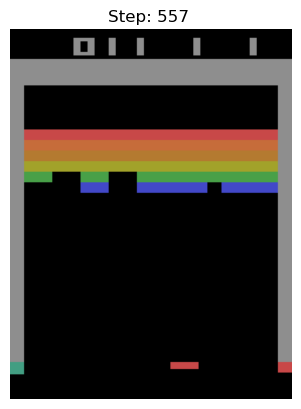

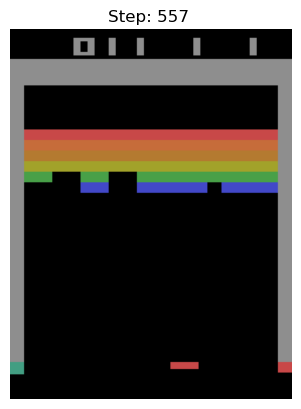

In [31]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo


# set random seed to sync visual and recorded game
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Load and setup Agent
# Choose whether to use double DQN
double_dqn = False # set to True if using double DQN agent
if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

#Initialize agent
print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/Run1_serial/good_breakout_dqn_1256_eps.pth")
agent.policy_net.eval()
agent.epsilon = 0  # Set agent to only exploit the best action


# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="rgb_array")
# Use RecordVideo to save the video to the "videos" directory
# env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda episode_id: True)

# Reset the environment
state, _ = env.reset(seed=seed)

# Setup History
history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
get_init_state(history, state, HISTORY_SIZE)

#Initialize variables
step = 0
done = False
fire_ready = True
life = number_lives
score = 0

while not done:

    # Render the current frame live in the notebook
    show_state_live(state, step)   

    # Select action
    if fire_ready:
        action = 1
        fire_ready = False
    else:
        model_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        action = TRAINABLE_ACTIONS[model_action]

    # Step the environment
    next_state, reward, term, trunc, info = env.step(action)
    done = term or trunc

    # update history
    frame_next_state = get_frame(state)
    history[4, :, :] = frame_next_state
    history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
    
    # check if life has been lost
    lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
    if lost_life:
        fire_ready = True  
        # do_random_actions(env_human, 30) #IMPT: introduce randomness to game and paddle position before next life
    life = info['lives']
    
    # keep track of score
    score += reward # update total score

    state = next_state
    step += 1

    

env.close()

## SCRATCH

In [33]:
for i in range(4):
    print(i)


0
1
2
3


In [92]:
sample=[]
history_size = 4
batch_size = 3
memory = [[np.random.rand(2, 2).round(1), 'action', 'reward', 'done'] for _ in range(101)] # Example memory with 100 elements
idx_sample = random.sample(range(100-history_size), batch_size)
print("index sample: ", idx_sample) 


mini_batch = []
for i in idx_sample:
    sample = []
    for j in range(history_size + 1):
        sample.append(memory[i + j])

    sample = np.array(sample, dtype=object)
    # print("sample: \n", sample)
    mini_batch.append((np.stack(sample[:, 0], axis=0), sample[3, 1], sample[3, 2], sample[3, 3]))

print("mini_batch: \n", mini_batch)
mini_batch = np.array(mini_batch, dtype=object).transpose()
print("mini_batch transpose: \n", mini_batch)
# print("mini_batch transposed[0][0]: \n", mini_batch[0][0])
history = np.stack(mini_batch[0], axis=0)
print("history: \n", history)
print(history.shape)

    




index sample:  [32, 25, 47]
mini_batch: 
 [(array([[[0.1, 0.7],
        [0.7, 0.2]],

       [[0.1, 0.6],
        [0.7, 0.1]],

       [[0.1, 0.7],
        [0.8, 0. ]],

       [[0.1, 0.5],
        [0.8, 0. ]],

       [[0.2, 0. ],
        [0.4, 0.3]]]), 'action', 'reward', 'done'), (array([[[0.9, 0.3],
        [0.3, 0.4]],

       [[0.6, 0.7],
        [0.8, 0.6]],

       [[0.3, 0.7],
        [0.1, 0.7]],

       [[0.1, 0.6],
        [0.7, 0.9]],

       [[0.4, 0.3],
        [0.3, 0.6]]]), 'action', 'reward', 'done'), (array([[[1. , 0.5],
        [0.4, 0.6]],

       [[0.2, 0.2],
        [0.5, 0.1]],

       [[0.9, 0.2],
        [0.3, 0.3]],

       [[0. , 0.1],
        [0.4, 0. ]],

       [[0.6, 0.8],
        [0.7, 0.5]]]), 'action', 'reward', 'done')]
mini_batch transpose: 
 [[array([[[0.1, 0.7],
          [0.7, 0.2]],

         [[0.1, 0.6],
          [0.7, 0.1]],

         [[0.1, 0.7],
          [0.8, 0. ]],

         [[0.1, 0.5],
          [0.8, 0. ]],

         [[0.2, 0. ],
    

In [ ]:
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False)
env.reset()
next_state, reward, terminations, truncations, info = env.step(torch.tensor([[1]]))
done = truncations or terminations
print("reward: ", reward)
print("done: ", done)
print("info: ", info)
print(next_state.shape)

action:  tensor([[3]], device='cuda:0')
reward:  0.0
done:  False
info:  {'lives': 5, 'episode_frame_number': 4, 'frame_number': 4}
(210, 160, 3)


In [22]:
print(env.action_space)
print("Expected type:", type(env.action_space.sample()))

Discrete(4)
Expected type: <class 'numpy.int64'>


In [29]:
print("agent memory type: ", type(agent.memory.memory[0]))
print("agent memory[0]: ", agent.memory.memory[0])

agent memory type:  <class 'tuple'>
agent memory[0]:  (array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), tensor([[0]]), 0.0, False)
